# Questions

## New:
transform(round(3)) raises an error

## Old:

1. The idea is to change the threshold in LogisticRegression, on which it divises positives from negatives. This information can be withdrawn with roc curve, right? But on roc curve you have the rates on every probability threshold, right? And on precision-recall curve as well. How to get access to confusion matrix at any threshold?
2. Or, if it's not possible, how to deduce either from ROC_AUC rates, or from Precision_Recall rates, at which threshold the ratio of False_Positive to False_Negative is N? (for example N=10, but can be 8 or 22 - depends how much costs to the bank the error of a wrong positive prediction vs a wrong negative one).
3. Gridsearch, the paramter "return_train_score", does it impact on the refit? Or it only it makes it show the train score? I'd like to make the refit based on the test score, not hte train one.
4. __The main question:__ the maskers in shap.LinearExplainer. my code doesn't work without it, but there are many examples where it's not required. Even on the sites in the recommendation list in "Ressources" section. How the code of other people works without these maskers?
5. What's the difference between the histogram HOUR_APPR_PROCESS_START and othrs, why this one looks like sawteeth but not the other variables histograms? How can I make the curve smoother?

## Old:
1. "Get feture importances", the section in the end of the notebook. How to get the features out from the pipeline, which is the outer wrapper? Or how to get the features from ColumnTransformer (which is called Preprocessor)?

I found in internet that this job is impossible when the column transformer contains Pipelines. But the inverse isn't mentioned as impossible.
This source https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep007/proposal.html sets the problem but doesn't offer a solution. It suggests to add feature_names_in_ attribute and get_feature_names_out method to fitted estimators. But I don't see how to do that.

2. kde graph, is there a way to reduce the wiggling of the curve? Can I stay with distribution and not pass to histograms? because of the difference of the scale.

In [1]:
# conda install -c conda-forge lightgbm
# pip install imbalanced-learn
# pip install shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time # in Kernel just import time
from os import listdir

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline #, make_union
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.metrics import precision_score, recall_score, make_scorer, confusion_matrix, classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score

from imblearn.pipeline import make_pipeline as make_pipeline_imblearn
from imblearn.over_sampling import SMOTE
# import imblearn
import shap


rasta = 1
rasta_smote = 1
rasta_class = 1


import gc
# from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
print(sklearn.__version__)#'0.24.2'
print(np.__version__) # '1.20.3'
print(pd.__version__)# '1.3.4'
# print(imblearn.__version__) # '0.9.0' # need to import the whole imblearn library to get the version

1.0.2
1.20.3
1.3.4


In [3]:
# from os import listdir
# path_csvs = 'C:\\Users\\Veronika\\DATABASES\\p7_credit_default_risk_dataset\\'
path_csvs = 'C:\\vb\\DATABASES\\p7_credit_default_risk_dataset\\'

list_files = [file for file in listdir(path_csvs)]

print(list_files)

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [4]:
# HomeCredit_columns_description = pd.read_csv(path_csvs + 'HomeCredit_columns_description.csv') # UnicodeDecodeError: 'utf-8' codec can't decode byte 0x85 in position 1283: invalid start byte

HomeCredit_columns_description = pd.read_csv(path_csvs + 'HomeCredit_columns_description.csv', encoding= 'unicode_escape')
HomeCredit_columns_description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


Clients income type (businessman, working, maternity leave,)

The unreadable symbol is an ellipsis. When I replaced it with "etc.", it raised an error in a later position: 26,931 instead of 1283. 
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x85 in position 26931: invalid start byte


In [5]:
print(HomeCredit_columns_description.Table.unique())

['application_{train|test}.csv' 'bureau.csv' 'bureau_balance.csv'
 'POS_CASH_balance.csv' 'credit_card_balance.csv'
 'previous_application.csv' 'installments_payments.csv']


In [6]:
# HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'POS_CASH_balance.csv', ['Row', 'Description']]

In [7]:
# HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'credit_card_balance.csv', ['Row', 'Description']]


In [8]:
# HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'previous_application.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

In [9]:
# HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'installments_payments.csv', ['Row', 'Description']]


In [10]:
# pd.set_option('max_rows', None)
# HomeCredit_columns_description.loc[HomeCredit_columns_description.Special.notna(), ['Row', 'Description', 'Special']]
# pd.reset_option('max_rows')

In [11]:
pd.reset_option("max_rows")
pd.get_option("max_rows")

60

# Aplication table

In [12]:
# appli_tr = pd.read_csv(path_csvs + 'application_train.csv', nrows= 10_000)
appli_tr = pd.read_csv(path_csvs + 'application_train.csv')
appli_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [13]:
pd.set_option('max_colwidth', None)
pd.set_option('max_rows', None)

display(HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'application_{train|test}.csv', ['Row', 'Description', 'Special']])

pd.reset_option('max_rows')

,Row,Description,Special
0,SK_ID_CURR,ID of loan in our sample,NaN
1,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,CODE_GENDER,Gender of the client,NaN
4,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,CNT_CHILDREN,Number of children the client has,NaN
7,AMT_INCOME_TOTAL,Income of the client,NaN
8,AMT_CREDIT,Credit amount of the loan,NaN
9,AMT_ANNUITY,Loan annuity,NaN


## Categorical variables

### Feature alanysis

In [14]:
# appli_tr.describe() # 106 columns, hard to follow
test = appli_tr.describe(include=object).transpose()
# test['missing'] = (test['count'] / appli_tr.shape[0] * 100).transform(round) # transform(round(3)) raises an error
test['missing'] = ((1-test['count'] / appli_tr.shape[0]) * 100).transform(lambda x: x.round(3))
test['freq%top'] = test.freq / appli_tr.shape[0] * 100
test['count'] = appli_tr.shape[0] - test['count']

display(test)

,count,unique,top,freq,missing,freq%top
NAME_CONTRACT_TYPE,0,2,Cash loans,278232,0.000,90.478715
CODE_GENDER,0,3,F,202448,0.000,65.834393
FLAG_OWN_CAR,0,2,N,202924,0.000,65.989184
FLAG_OWN_REALTY,0,2,Y,213312,0.000,69.367275
NAME_TYPE_SUITE,1292,7,Unaccompanied,248526,0.420,80.818572
NAME_INCOME_TYPE,0,8,Working,158774,0.000,51.631974
NAME_EDUCATION_TYPE,0,5,Secondary / secondary special,218391,0.000,71.018923
NAME_FAMILY_STATUS,0,6,Married,196432,0.000,63.87804
NAME_HOUSING_TYPE,0,6,House / apartment,272868,0.000,88.734387
OCCUPATION_TYPE,96391,18,Laborers,55186,31.346,17.946025


In [15]:
selectcol = appli_tr.select_dtypes(include=object)
selectcol = selectcol.fillna('missing_value')
selectcol['SK_ID_CURR'] = appli_tr['SK_ID_CURR']
selectcol['TARGET'] = appli_tr['TARGET']

In [16]:
# FIXED THE BUG removed default value (which is a big database and memory-consuming). Now I must enter the my_df name every time I call the function
# # WARNING: if I don't put the same function every time, the notbook rises an error! That happens because parameter my_df stores the link to the object Dataframe. Instead of looking every time for the object we have a saved dataframe under the name selectcol

def find_most_risky(my_col, my_df, show=True):
    if show:
        print(appli_tr[my_col].value_counts(dropna=False))

    test = my_df.groupby(['TARGET', my_col])['SK_ID_CURR'].agg('size').unstack().fillna(0)

    test1 = pd.DataFrame() # which proportion of every value has failed the credit 
    for col in test: # how high chances are that a given person with a given value will fail the credit
#         print(col)
        test1[col] = test[col] / test[col].sum() * 100  # aggregate my mean instead
    test1 = test1.transpose().sort_values(1, ascending=False)
    test1['proportion'] = [(my_df[my_col] == value).mean() * 100 for value in test1.index]
    test1 = test1.sort_values('proportion', ascending=False)
#     test1 = test1.sort_values(1, ascending=False)
    
    if test1.shape[0] > 2:
        print(test1[1].max() / (test1[1].min() + 0.00001), 'times varies the probability to fail')
        print(test1[1].max() / test1.iloc[0, 1], 'times the highest probability is higher than the most frequent one.')
    
    print('ratio of fail for second major class to fail for the major one is', test1.iloc[1, 1] / test1.iloc[0, 1])
    print('ratio of fail for the major class to fail for second major one is', test1.iloc[0, 1] / test1.iloc[1, 1])
    if show:
        display(test1)
    return test1#.reset_index()

For every categorical column, I calculate how many percents of loaners are failed their loan for every available value. That allows to estimate is there's a difference, and approximately estimate how strong this difference is. In other words, how strong is the impact of this feature on target, regardless other features.

It doesn't take into account the interactions between variables. Like, that that the a1&b1 is good, a2&b2 is good, but a2&b1 is bad, a1b2 is bad. Like a saddle point. But alltogether over "a" or "b", you only see no difference in probability.

With the high impact features (that I will see at the step of Shap values explication), I will try to replace these columns with the probability of find 1 and see whether the model performance decreases.
About low impact values, with low shap values, I will delete these values and see whether, and how much, the performance drops.

In [17]:
# find_most_risky('NAME_CONTRACT_TYPE', selectcol) # cash 8.3, revolving 5.4
# find_most_risky('CODE_GENDER', selectcol) # F 7.0, M 10.1, XNA equals NaN 0 (0 out of 4 people)
# find_most_risky('FLAG_OWN_CAR', selectcol)
# find_most_risky('FLAG_OWN_REALTY', selectcol) # No 8.32 Yes 7.96
# find_most_risky('NAME_TYPE_SUITE', selectcol) # NaN 5.4(min), Other_B 9.8 (max value)
# find_most_risky('NAME_INCOME_TYPE', selectcol) # Businessman 0(min value), maternity leave 40 (max value), unemployed 36.4
# find_most_risky('NAME_EDUCATION_TYPE', selectcol) # correlation, but not linear: monotonic, but not proportional! academic 1.8, lower secondary 10.9
# find_most_risky('NAME_FAMILY_STATUS', selectcol) # widow 5.8(min), civil marriage 9.9(max), single 9.8, unknown = NaN 0 (0 out of 2)
# find_most_risky('NAME_HOUSING_TYPE', selectcol) # office appartment 6.5(min), rented apartment 12.3 (max value), with parents 11.7
# find_most_risky('OCCUPATION_TYPE', selectcol) # 19 DIMENSIONS! accountants 4.8(min), low-skill Laborers 17.1 (max value)
# find_most_risky('WEEKDAY_APPR_PROCESS_START', selectcol) # Mon7.75(min), Sat7.78, Sun7.92, Tue8.35(max). delete?
# find_most_risky('ORGANIZATION_TYPE', selectcol) # 58 DIMENSIONS! tradeType4 3.12(min), transportType3 15.75(max)
# find_most_risky('FONDKAPREMONT_MODE', selectcol) # orgSpecAcc 5.8 (min), unknown 8.6 (max), "not specified" means NaN 7.5
# find_most_risky('HOUSETYPE_MODE', selectcol) # blockOfFLats 6.9, specificHousing 10.1(max), NaN 9.15
# find_most_risky('WALLSMATERIAL_MODE', selectcol) # Monolithic 4.72(min), wooden 9.69, unknown 9.12
find_most_risky('EMERGENCYSTATE_MODE', selectcol) # No 7.0, Yes 9.57, NaN 9.26

No     159428
NaN    145755
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64
1.3753283914169894 times varies the probability to fail
1.3753303660734624 times the highest probability is higher than the most frequent one.
ratio of fail for second major class to fail for the major one is 1.329630923037425
ratio of fail for the major class to fail for second major one is 0.7520884048902743


TARGET,0,1,proportion
No,93.035100,6.964900,51.844649
missing_value,90.739254,9.260746,47.398304
Yes,90.420962,9.579038,0.757046


TARGET,0,1,proportion
No,93.035100,6.964900,51.844649
missing_value,90.739254,9.260746,47.398304
Yes,90.420962,9.579038,0.757046


How do I take decision based on what "find the most risky" function shows:
- If some values have high risks (above 20%), it may worth to include this variable anyway. Look individually.
- Is the distribution of the values balanced? If at least 20% is in a class other than the major, Iconsider it "balanced". In other words, if at least 2 classes have the proportion above 20% or, it's balanced. Then, if the ratio (maximal probability of fail class)/(minimal probability of fail class) is 1.5 or higher, I KEEP THIS FEATURE.
- Otherwise, the distribution is imbalanced. If there's only 1 class above 20% occurence.
- Then I use a grid, created more or less arbitrarily:
    - if the minor class is above 10% proportion, increase in fail probability should be at least 75%.
    - if the minor class is above 5%, the increase in probability should be at least 100% (probability 2 times higher)
    - if the minor class is above 2%, the increase in probability should be at least 100% (probability 3 times higher) 
    - if the minor class is above 1%, the increase in probability should be at least 200% (probability 4 times higher)
This is an approximate guideline. If I see individual cases that suggest it worth keep the variable, I will keep it.

- NAME_CONTRACT_TYPE: cash 8.3, revolving 5.4 (9.5%) DROP THIS FEATURE? the fail risk for the minor class doesn't increase, but decrease. On the other hand, the ratio is significant, 1.52 times. I will keep it, but will also try the model without this feature. __UPD: apparently the performance is a bit lower without it, so I will keep it.__
- CODE_GENDER: F 7.0, M 10.1, XNA equals NaN 0 (0 out of 4 people) REPLACE VALUE XNA. Redo the analysis. KEEP THIS FEATURE: balanced distribution, keep the variable.  -> feature engineering (combine with age, see section "Integer values")
- FLAG_OWN_CAR: No 8.5, Yes 7.2(35%) DROP THIS FEATURE? the ratio is 1.17, according to my metrics I should drop it. well let's keep it but I suggest to compare to try without it as well. __UPD: apparently the performance is a bit lower without it, so I will keep it.__
- FLAG_OWN_REALTY: No 8.32 Yes 7.96(35%) DROP THIS FEATURE? yes. balanced distribution, but ratio only 1.05
- NAME_TYPE_SUITE: NaN 5.4(min), Other_B 9.8 (max value) DROP THIS FEATURE? yes. distribution is almost balanced. The chance of fail is actually not increasing forthe second major class, but decreasing. Though not a lot, less than 10%. The most risky group is 1.2 times higher than the major group, but the proportion of those people is tiny.
- NAME_INCOME_TYPE: Businessman 0(min value), maternity leave 40 (max value), unemployed 36.4 DROP THIS FEATURE? no! we have the categories Maternity_leave with 40% risk of fail (0.1% cases) and Unemployed with 36.4% (0.7%)
- NAME_EDUCATION_TYPE: keep this feature: balanced distribution, second major class is 60% from the major one to fail.
- NAME_FAMILY_STATUS: widow 5.8(min), civil marriage 9.9(max), single 9.8, unknown = NaN 0 (0 out of 2)  DROP THIS FEATURE? the ratio is 1.17, according to my metrics I should drop it. well let's keep it but I suggest to compare to try without it as well. __UPD: no effect on the success of the model. We can drop it.__
- NAME_HOUSING_TYPE: office appartment 6.5(min), rented apartment 12.3 (max value), with parents 11.7  DROP THIS FEATURE? the best is to modify this variable:
    - With parents(11.7) or rented(12.3) = A, others = B. Maybe office appartment (6.6%) = C
        but this will lead to overfitting of the model.
    but it's worth keeping - the metrics indicate variable is valuable. I will keep it, but will also try the model without this feature. __UPD: apparently the performance is a bit lower without it, so I will keep it.__
- OCCUPATION_TYPE: 19 DIMENSIONS! accountants 4.8(min), low-skill Laborers 17.1 (max value)  DROP THIS FEATURE? one of the approaches is to modify the values: 
    - name "low-skill laborers" (17%) "low-skill laborers and unemployed",
    - group Drivers, Waiters/barmen staff, Security staff, Laborers, Cooking staff, Sales staff, Cleaning staff (11.2-9.6)
    - group the rest (7.8-6.15)
    - Accountants (4.8%)  
But that may cause model overfitting: because we group variables based on target
- WEEKDAY_APPR_PROCESS_START: DROP THIS FEATURE? certainly yes: the difference is minor
- ORGANIZATION_TYPE: 58 DIMENSIONS! tradeType4 3.12(min), transportType3 15.75(max) DROP THIS FEATURE? one :
    - put separately 1st 3 (16 - 12.5)
    - group next 4 (11.7 - 11.1)
    - group next 12 (10.6 - 8.9)
    - group next 24 (8.6 - 6.4)
    - group last 15 (6.1- 3.1)  
But that may cause model overfitting: because we group variables based on target
- FONDKAPREMONT_MODE: orgSpecAcc 5.8 (min), unknown 8.6 (max), DROP THIS FEATURE? balanced distribution, the difference is slightly above the metric. I would suggest to drop it, but also compare the results with this metric and without it. __UPD: no effect on the success of the model. We can drop it.__
- HOUSETYPE_MODE: blockOfFLats 6.9, specificHousing 10.1(max), NaN 9.15 DROP THIS FEATURE? well it doesn't fit in the metric. According to my metrics I should drop it. well let's keep it but I suggest to compare to try without it as well. __UPD: no effect on the success of the model. We can drop it.__
- WALLSMATERIAL_MODE: well it doesn't fit in the metric. According to my metrics I should drop it. well let's keep it but I suggest to compare to try without it as well. __UPD: no effect on the success of the model. We can drop it.__
- EMERGENCYSTATE_MODE: well it doesn't fit in the metric. According to my metrics I should drop it. well let's keep it but I suggest to compare to try without it as well. __UPD: apparently the performance is a bit lower without it, so I will keep it.__ Maybe it's because there are only 2 values, Yes and No, it's like a flag?

### Function for replacement of categorical variable to the proportion of fails, given the value

The purpose is to reduce dimensions. The potential drawback is that the train test split will be not homogenous, which will create the biased probabilities/weights of fail. But it worth trying, because it allows to reduce the dimension of 'OCCUPATION_TYPE' from 19 to 1 and 'ORGANIZTION_TYPE' from 58 to 1.

I will apply this function after the exploration of numeric variables. Because each converted variable changes type from "object" to "float" and will bother on the float variables exploration step.

In [18]:
def category_to_fail_proportion(my_df, my_series, fill=True): # my_series should be a string
    probas_table = find_most_risky(my_series, my_df=my_df, show=False)
    proba_series = my_df[my_series].transform(lambda x: probas_table.loc[x, 1]) # works faster than the "for" cycle with item and lines selection for every item
    if fill:
        proba_series = proba_series.fillna(probas_table.iloc[0, 1])
    return proba_series#, probas_table


WARNING: I never can apply this function because it leads to overfitting of the model: it uses the target (y) for the calculation of the features (X).
Though, this function can be applied, if during cross-validation the probabilities are withdrawn only from train set and then imputed in test set as is.

### Values imputing strategy: Cautious strategy
The strategy is not the same for filling the train set and the test set:
- For the test set, if we don't know the value, we shall use the most "risky" variant: the value that gives the highest rate of positive target.
- For the train set, we know the traget. So, if the target is negative, no need to set the parameter to the "most risky" category. I will assign it to the a category (more on that later), if the number of missing values is below the limit (let's say arbitrarily, 5%) and to a standalone "unknown" category, if the number of missing values is above this limit.
- How to choose a category: we already know the target value. So, for the positive target we give the "most risky" value to the unknown. For the negative target, we give the most frequent value, doesn't matter what's the risk (can be the most risky, the least, or somewhere in the middle, we just take the most frequent).
- The drawback of such a distiction on the category: we risk to overfit our model. But, we will overfit it in a lopsided way: the model will tend to give more importance on the imputed features to lead to positive target. But this drawback plays on our side at the end of the game: as on test set we impute the "most risky" value every time, the model will give more false negatives, but will be much less likely to let pass the false positives. That means, we can explain the refuse to a client based on the features that were not provided by the client, so the client knows what cells (s)he has to modify or fill.
- How we detect "the most risky" category: by groupby-aggregation test. Look the correlation between positive target (credit fail) and different values. See the proportion of people who failed to pay their credit for every value. The value with the highest proportion of positive target is "the most risky" one.
- How to store "the most risky" values: maybe as a dictionary. The key is the feature that we want to impute, the value is the most risky category.

#### When to apply cautious strategy
When we suppose that a false positive is significantly more costly to the bank than a false negative is. If it happens that the difference between the cost of false negative and false positive is insignificant for the bank, we can pass to simplified strategy.
### Values imputing strategy: Simplified strategy
Impute with "the most risky" value for test set and with the most frequent value for the train set.
### Values imputing strategy: Simplest strategy
Impute with the most frequent value for both train and test sets.
### How to handle the values which are already imputed as "unknown", "not specified", "XNA" or similar
When you look through unique values, you might notice that some categorical values are filled with "unknown", "not_specified", "XNA" or similar kinds of values. All that means "NaN", basically.
The best of all would be to ask a confirmation on the business side, whether it's indeed smth like "this info is lacking", which equelas NaN.

If it is so, the best is to delete these values/replace by "NaN", and then apply the standard algorithm, described before.

Example: GENDER_CODE. Among 307511 applications, 4 applicants have "XNA" value. It's like "nan", just it's filled with text. So I will replace "XNA" with "nan", and then treat it along the general algorithm:
    it's less than 5% NaNs, so impute 
    -with most risky for test set, 
    -with  most risky for train set positive target, 
    - with most frequent for train set negtive target.
The most risky value from groupby-aggreagtion test is "M".

WARNING: I never can apply the "Cautious strategy" (neither "Simplified strategy") because it leads to overfitting of the model: it uses the target (y) for the calculation of the features (X).
Though, both these strategies can be applied, if during cross-validation the probabilities are withdrawn only from train set and then imputed in test set as is.

### Which imputing  and/or replacing strategy is better for each of missing categorical values

CODE_GENDER: Unknown is the least failed category. With the simplest strategy we tend to rise the failure impact from 0 to 7.0. With cautious strategy - rise even higher, from 0 to 10.1. __Simplest__ strategy is closer to reality.
_the proportion of NaNs is low, 0.001%, we can't take them into a separated category_

NAME_TYPE_SUITE: Unknown is the least failed category. With the simplest strategy we tend to rise the failure impact from 5.4 to 8.2. With cautious strategy - rise even higher, from 5.4 to 9.8. __Simplest__ strategy is closer to reality.
_the proportion of NaNs is low, 0.42%, we can't take them into a separated category_

NAME_FAMILY_STATUS: Unknown is the least failed category. With the simplest strategy we tend to rise the failure impact from 0 to 7.56. With cautious strategy - rise even higher, from 0 to 9.94. __Simplest__ strategy is closer to reality.
_the proportion of NaNs is low, 0.001%, we can't take them into a separated category_

OCCUPATION_TYPE: With the simplest strategy we tend to rise the failure impact from 6.5 to 10.5 (most frequent group is Laborers). With cautious strategy - rise even higher, from 6.5 to 17.1. __Simplest__ strategy is closer to reality.
_as the proportion of NaNs is higher than 5%, we can take them apart, and this is better than both simplest or cautious_

FONDKAPREMONT_MODE: With the simplest strategy we tend to bring down the failure impact from 8.6 to 7.0 (most frequent group is reg oper account). With cautious strategy - bring down less, from 8.6 to 7.5. __Cautious__ strategy is closer to reality.
Here, as we have the category "not specified", we can combine them. That would be equal to cautious strategy.
Or, _as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension, so let's just replace "not specified" with NaN and combine with NaNs into a separate category._

HOUSETYPE_MODE: With the simplest strategy we tend to bring down the failure impact from 9.15 to 7.0 (most frequent group is block of flats). With cautious strategy - to rise the failure from 9.15 to 10.1. __Cautious__ strategy is closer to reality.
Here, as we have the category "not specified", we can combine them. That would be equal to cautious strategy.
_as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension._

WALLSMATERIAL_MODE: With the simplest strategy we tend to bring down the failure impact from 9.1 to 6.3 (most frequent group is panel). With cautious strategy - to rise the failure from 9.1 to 9.7. __Cautious__ strategy is closer to reality.
_as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension._

EMERGENCYSTATE_MODE: With the simplest strategy we tend to bring down the failure impact from 9.3 to 7.0 (most frequent group is No). With cautious strategy - to rise the failure from 9.3 to 9.6. __Cautious__ strategy is closer to reality.
_as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension._

In [19]:
appli_tr.select_dtypes(include=object).loc[:, appli_tr.isnull().any()].columns

Index(['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

At this step, I will replace all the missing values with simplest strategy, but I will choose the string to fill by different strategies: simplest where it's closer to reality, cautious where it's closer to reality.

In [20]:
appli_tr.loc[appli_tr.CODE_GENDER == 'XNA', 'CODE_GENDER'] = 'F' # as most frequent: only 4 people of 307,511 have XNA value
appli_tr.loc[appli_tr.NAME_FAMILY_STATUS == 'Unknown', 'NAME_FAMILY_STATUS'] = 'Single / not married' # only 2 people of 307,511 have Unknown value, and I don't want to create a new OneHotEncoded variable which has only 2 "1"s. why single: as "default status" or "initial status" of a person

In [21]:
appli_tr['NAME_TYPE_SUITE'] = appli_tr.NAME_TYPE_SUITE.fillna('Unaccompanied') # most frequent
appli_tr['OCCUPATION_TYPE'] = appli_tr.OCCUPATION_TYPE.fillna('unknown') # new category
appli_tr['FONDKAPREMONT_MODE'] = appli_tr.FONDKAPREMONT_MODE.fillna('not specified') # merged with "not specified", most frequent
appli_tr['HOUSETYPE_MODE'] = appli_tr.HOUSETYPE_MODE.fillna('unknown') # new category
appli_tr['WALLSMATERIAL_MODE'] = appli_tr.WALLSMATERIAL_MODE.fillna('Others') # most "neutral", when we don't know
appli_tr['EMERGENCYSTATE_MODE'] = appli_tr.EMERGENCYSTATE_MODE.fillna('Yes') # we may expect the worst


### Feature selection
This is an iterative process, because I look at the results of shap explanation, and then check if the performance stays stable if I remove this value.

In [22]:
appli_tr = appli_tr.drop(['WEEKDAY_APPR_PROCESS_START', 
#                           'FLAG_OWN_CAR', 
                          'FLAG_OWN_REALTY',
                          'NAME_TYPE_SUITE',
                          'NAME_FAMILY_STATUS',
#                           'ORGANIZATION_TYPE',
                          'FONDKAPREMONT_MODE',
#                           'HOUSETYPE_MODE',
                          'WALLSMATERIAL_MODE',
#                           'EMERGENCYSTATE_MODE' # has just 1 column
                         ], axis=1)

## Flags
Let's look for the most risky category for each falag value. Flags are integers, but since they have finite numbers of values, I can apply to them "find the most risky" function, the same way that I did to categorial variables.

This function will allow to see fast whether there's a correlation between the target and these integers with limited ans small number of values they can take.

Eventually I can check in this same way even the integers that have more than 2 or 3 flag values.
Like I checked the categorical having 58 values.

In [23]:
# appli_tr.describe() # 106 columns, hard to follow
test = appli_tr.describe(include=int).transpose()[6:].sort_values('std')
# first 12 lines were finally deleted except FLAG_DOC_21
# nothing is missing! if there are NaNs, the column datatype switches from int to float
# display(test)

We don't have missing values (because if you do, the column datatype will turn to float right away), so no need to impute

In [24]:
selectcol = appli_tr.select_dtypes(include=int)
selectcol = selectcol.fillna(900_000)
selectcol['SK_ID_CURR'] = appli_tr['SK_ID_CURR']
selectcol['TARGET'] = appli_tr['TARGET']
selectcol['CNT_FAM_MEMBERS'] = appli_tr['CNT_FAM_MEMBERS'].fillna(900_000)

In [25]:
# find_most_risky('FLAG_MOBIL', selectcol) 
# find_most_risky('FLAG_EMP_PHONE', selectcol) 
# find_most_risky('FLAG_WORK_PHONE', selectcol)
# find_most_risky('FLAG_CONT_MOBILE', selectcol)
# find_most_risky('FLAG_PHONE', selectcol) 
# find_most_risky('FLAG_EMAIL', selectcol) 

find_most_risky('REGION_RATING_CLIENT', selectcol) # 11%, 7% and 4% fail. absolutely need to include.
find_most_risky('REGION_RATING_CLIENT_W_CITY', selectcol) # the same. check if correlates with REGION_RATING_CLIENT

# find_most_risky('REG_REGION_NOT_LIVE_REGION', selectcol) 
# find_most_risky('REG_REGION_NOT_WORK_REGION', selectcol) 
# find_most_risky('LIVE_REGION_NOT_WORK_REGION', selectcol) 
# find_most_risky('REG_CITY_NOT_LIVE_CITY', selectcol)
# find_most_risky('REG_CITY_NOT_WORK_CITY', selectcol)
# find_most_risky('LIVE_CITY_NOT_WORK_CITY', selectcol)

# find_most_risky('FLAG_DOCUMENT_2', selectcol) # 30% fail with 1 (of 30 people), 8% fail with no 
# find_most_risky('FLAG_DOCUMENT_3', selectcol) # 8.8 vs 6.1 to fail. DROP THIS FEATURE? yes
# find_most_risky('FLAG_DOCUMENT_4', selectcol) # 25 people have flag, target 0 of 25. it's like doc2 but inverse
# find_most_risky('FLAG_DOCUMENT_5', selectcol) # 8.07 vs 8.0. DROP THIS FEATURE
# find_most_risky('FLAG_DOCUMENT_6', selectcol) # 8.3 vs 5.56 to fail
# find_most_risky('FLAG_DOCUMENT_7', selectcol) # 8.1 vs 5.1 to fail, 57 people have it. drop? no
# find_most_risky('FLAG_DOCUMENT_8', selectcol) # 8.1 vs 7.3 to fail. 25,000 people have it. drop? no
# find_most_risky('FLAG_DOCUMENT_9', selectcol) # 8.1 vs 6.1 to fail.  1200 people have it. drop? no
# find_most_risky('FLAG_DOCUMENT_10', selectcol) # 7 people have flag, target 0 of 7. DROP THIS FEATURE
# find_most_risky('FLAG_DOCUMENT_11', selectcol) # 8.1 vs 6.2 to fail, 1203 pepole have it. drop? no
# find_most_risky('FLAG_DOCUMENT_12', selectcol)  # 2 people have flag, target 0 of 2. drop? no. but only 2 people
# find_most_risky('FLAG_DOCUMENT_13', selectcol) # 8.1 (all) vs 2.7 (1200 people)
# find_most_risky('FLAG_DOCUMENT_14', selectcol) # 8.1 vs 3.3 (903 people)
# find_most_risky('FLAG_DOCUMENT_15', selectcol) # 8.1 vs 3.0 (372 people)
# find_most_risky('FLAG_DOCUMENT_16', selectcol) # 8.1 vs 4.9 (3,000 people)
# find_most_risky('FLAG_DOCUMENT_17', selectcol) # 8.1 vs 2.4 (82 people). drop? no. but there are few people
# find_most_risky('FLAG_DOCUMENT_18', selectcol) # 8.1 vs 5.7 (2500 people)
# find_most_risky('FLAG_DOCUMENT_19', selectcol) # 8.1 vs 6.55 (183 people). drop? no. but there are few people
# find_most_risky('FLAG_DOCUMENT_20', selectcol) # 8.1 vs 8.3(156 people). DROP THIS FEATURE
# find_most_risky('FLAG_DOCUMENT_21', selectcol) # 8.1 vs 13.6 (103 people)


2    226984
3     48330
1     32197
Name: REGION_RATING_CLIENT, dtype: int64
2.3033326451786196 times varies the probability to fail
1.407363503997728 times the highest probability is higher than the most frequent one.
ratio of fail for second major class to fail for the major one is 1.407363503997728
ratio of fail for the major class to fail for second major one is 0.7105484810139103


TARGET,0,1,proportion
2,92.110898,7.889102,73.813294
3,88.897165,11.102835,15.716511
1,95.179675,4.820325,10.470195


2    229484
3     43860
1     34167
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64
2.355367469001958 times varies the probability to fail
1.4400769898518853 times the highest probability is higher than the most frequent one.
ratio of fail for second major class to fail for the major one is 1.4400769898518853
ratio of fail for the major class to fail for second major one is 0.6944073178357304


TARGET,0,1,proportion
2,92.082237,7.917763,74.626274
3,88.597811,11.402189,14.262904
1,95.159072,4.840928,11.110822


TARGET,0,1,proportion
2,92.082237,7.917763,74.626274
3,88.597811,11.402189,14.262904
1,95.159072,4.840928,11.110822


- FLAG_MOBIL: 1 person without mobile, target 0. DROP THIS FEATURE? certainly yes
- FLAG_EMP_PHONE: 8.6 vs 5.4 (55,000 people) KEEP
- FLAG_WORK_PHONE: 9.6 vs 7.7(61,000 people) balanced distribution, the ratio is 1.25  __UPD: apparently the performance is a bit lower without it, so I will keep it.__
- FLAG_CONT_MOBILE: 8.1 vs 7.8(574 people) imbalanced distribution, the ratio is 1.02 DROP THIS FEATURE? certainly yes
- FLAG_PHONE: 8.5 vs 7.0 (86,000 people) balanced distribution, the ratio is 1.2 __UPD: apparently the performance is a bit lower without it, so I will keep it.__
- FLAG_EMAIL:  8.1 vs 7.9 (17400 people) imbalanced distribution, the ratio is 1.02 DROP THIS FEATURE? certainly yes

- REGION_RATING_CLIENT: 11%, 7% and 4% fail. this is an ordinal variable. With clear correlation! Must include.
- REGION_RATING_CLIENT_W_CITY: 11%, 7% and 4% fail. check whether correlates with REGION_RATING_CLIENT  __correlates almost entirely, I drop REGION_RATING_CLIENT and keep REGION_RATING_CLIENT_W_CITY.__

- REG_REGION_NOT_LIVE_REGION: 8.1 vs 9.3 (4500 people) imbalanced distribution, the ratio is 1.15 DROP? certainly yes
- REG_REGION_NOT_WORK_REGION: 8.1 vs 8.9 (15,000 people) imbalanced distribution, the ratio is 1.10 DROP? certainly yes
- LIVE_REGION_NOT_WORK_REGION: 8.1 vs 8.4 (12,000 people) imbalanced distribution, the ratio is 1.05 DROP? certainly yes
- REG_CITY_NOT_LIVE_CITY: 7.7 vs 12.2 (24,000 people) less imbalanced distribution, the ratio is 1.58 KEEP
- REG_CITY_NOT_WORK_CITY: 7.3 vs 10.6 (70,000 people) balanced distribution, the ratio is 1.3 DROP? 
- LIVE_CITY_NOT_WORK_CITY: 7.6 vs 10.0 (55,000 people) DROP? __UPD: apparently the performance is a bit lower without it, so I will keep it.__

- FLAG_DOCUMENT_2: 30% fail with 1 (of 30 people), 8% fail with no KEEP
- FLAG_DOCUMENT_3: 8.8 vs 6.1 to fail. balanced distribution, ratio 1.43 KEEP
- FLAG_DOCUMENT_4: 25 people have flag, target 0 of 25. DROP THIS FEATURE? yes. it would be important if we were hunting the precision. __UPD: can drop__
- FLAG_DOCUMENT_5:  imbalanced distribution, the ratio is 1.00 DROP THIS FEATURE? certainly yes
- FLAG_DOCUMENT_6: 8.3 vs 5.56 to fail imbalanced distribution 10:1, the ratio is 0.66 DROP THIS FEATURE? yes. it would be important if we were hunting the precision. __UPD: apparently the performance is a bit lower without it, so I will keep it.__
- FLAG_DOCUMENT_7: 8.1 for 0 vs 5.1 for 1 to fail, 57 people have 1. DROP THIS FEATURE? certainly yes. it would be important if we were hunting the precision. __UPD: can drop__
- FLAG_DOCUMENT_8: 8.1 for 0 vs 7.3 for 1 to fail. 25,000 people have 1. imbalanced distribution 10:1, the ratio is 0.90 DROP THIS FEATURE? certainly yes. it would be important if we were hunting the precision.
- FLAG_DOCUMENT_9: 8.1 vs 6.1 to fail.  1200 people have it. imbalanced distribution 100:1, the ratio is 0.76 (1.3 times lower for minor value) DROP THIS FEATURE? yes. it would be important if we were hunting the precision.
- FLAG_DOCUMENT_10: 7 people have flag, target 0 of 7. DROP THIS FEATURE? yes. it would be important if we were hunting the precision. __UPD: can drop__
- FLAG_DOCUMENT_11: imbalanced distribution 100:1, the ratio is 0.76 DROP THIS FEATURE? yes. it would be important if we were hunting the precision.
- FLAG_DOCUMENT_12: 2 people have flag, target 0 of 2.  DROP THIS FEATURE? certainly yes. it would be important if we were hunting the precision.  __UPD: can drop__
- FLAG_DOCUMENT_13: 8.1 for 0 (all) vs 2.7 for 1 (1200 people)  imbalanced distribution 300:1, the ratio is 0.34 (3 times lower for minor value) DROP THIS FEATURE? yes. it would be important if we were hunting the precision.  __UPD: apparently the performance is a bit lower without it, so I will keep it.__
- FLAG_DOCUMENT_14: 8.1 for 0 vs 3.3 for 1 (903 people) imbalanced distribution 350:1, the ratio is 0.41 (2.5 times lower for minor value) DROP THIS FEATURE? yes. it would be important if we were hunting the precision.  __UPD: apparently the performance is a bit lower without it, so I will keep it.__
- FLAG_DOCUMENT_15: 8.1 for 0 vs 3.0 for 1 (372 people) imbalanced distribution 800:1, the ratio is 0.36 (2.5 times lower for minor value) DROP THIS FEATURE? yes. it would be important if we were hunting the precision.  __UPD: can drop__


- FLAG_DOCUMENT_16: 8.1 for 0 vs 4.9 for 1 (3,000 people)imbalanced distribution 100:1, the ratio is 0.6 (1.7 times lower for minor value) DROP THIS FEATURE? yes. it would be important if we were hunting the precision.  __UPD: apparently the performance is a bit lower without it, so I will keep it.__
- FLAG_DOCUMENT_17: 8.1 for 0 vs 2.4 for 1 (82 people) imbalanced distribution 3,000:1, the ratio is 0.3 (3.3 times lower for minor value) DROP THIS FEATURE? yes. it would be important if we were hunting the precision.  __UPD: can drop__


- FLAG_DOCUMENT_18: 8.1 vs 5.7 (2500 people) imbalanced distribution 100:1, the ratio is 0.7 (1.4 times lower for minor value) DROP THIS FEATURE? yes. it would be important if we were hunting the precision.  __UPD: can drop__
- FLAG_DOCUMENT_19: 8.1 vs 6.55 (183 people). imbalanced distribution 2,000:1, the ratio is 0.8 (1.2 times lower for minor value) certainly drop.
- FLAG_DOCUMENT_20: the ratio is 1.03. certainly drop
- FLAG_DOCUMENT_21: 8.1 vs 13.6 (103 people) imbalanced distribution 3,000:1, the ratio is 1.68 (3 times lower for minor value) DROP THIS FEATURE? it doesn't fit in the metrics.  __UPD: apparently the performance is a bit lower without it, so I will keep it.__


There is a tendencythat night applications have higher risk, maybe lunch applications too. Maybe people who feel their applications, are less likely to have a daytime job.

In [26]:
pd.DataFrame(confusion_matrix(selectcol.REGION_RATING_CLIENT, selectcol.REGION_RATING_CLIENT_W_CITY),
            index=['RR1', 'RR2', 'RR3'], columns=['RR_W_CITY1', 'RR_W_CITY2', 'RR_W_CITY3'])

,RR_W_CITY1,RR_W_CITY2,RR_W_CITY3
RR1,32197,0,0
RR2,1248,225736,0
RR3,722,3748,43860


Highly correlated values. Let's just double-check that in the applications where REGION_RATING_CLIENT is higher (better?) than REGION_RATING_CLIENT_W_CITY, the proportion of credit fail is higher.

Normally the smaller the number, the higher the rating. 1 is 4%, 2 is 7%, 3 is 11% of fail. It works for both REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY.

In the lines where REGION is 3 but REGION_W_CITY is 2, the probability is closer to 2 than to 3 (8 is closer to 7 than to 11)

In [27]:
# find_most_risky('REGION_RATING_CLIENT')
# find_most_risky('REGION_RATING_CLIENT_W_CITY')

test_df = selectcol[selectcol.REGION_RATING_CLIENT > selectcol.REGION_RATING_CLIENT_W_CITY]
# find_most_risky('REGION_RATING_CLIENT', test_df)
# find_most_risky('REGION_RATING_CLIENT_W_CITY', test_df)

test = test_df.groupby(['TARGET', 
                 'REGION_RATING_CLIENT', 
                 'REGION_RATING_CLIENT_W_CITY'])['SK_ID_CURR'].agg('count').unstack().unstack().fillna(0)

test1 = pd.DataFrame() # which proportion of every value has failed the credit 
for col in test: # how high chances are that a given person with a given value will fail the credit
    test1[col] = test[col] / test[col].sum() * 100
test1 = test1.transpose().sort_values(1, ascending=False)
display(test1)


TARGET,0,1
"(2, 3)",91.408751,8.591249
"(1, 3)",94.044321,5.955679
"(1, 2)",95.272436,4.727564
"(2, 2)",NaN,NaN


In [28]:
appli_tr['RATING_REGION'] = appli_tr.REGION_RATING_CLIENT + appli_tr.REGION_RATING_CLIENT_W_CITY
find_most_risky('RATING_REGION', appli_tr)#, show=False)

4    226458
6     43860
2     32197
5      3748
3      1248
Name: RATING_REGION, dtype: int64
2.411847711980975 times varies the probability to fail
1.4432490455005653 times the highest probability is higher than the most frequent one.
ratio of fail for second major class to fail for the major one is 1.4432490455005653
ratio of fail for the major class to fail for second major one is 0.6928811095476372


TARGET,0,1,proportion
4,92.099639,7.900361,73.642244
6,88.597811,11.402189,14.262904
2,95.179675,4.820325,10.470195
5,91.408751,8.591249,1.218818
3,95.272436,4.727564,0.405839


TARGET,0,1,proportion
4,92.099639,7.900361,73.642244
6,88.597811,11.402189,14.262904
2,95.179675,4.820325,10.470195
5,91.408751,8.591249,1.218818
3,95.272436,4.727564,0.405839


In [29]:
appli_tr.loc[appli_tr.CODE_GENDER == 'XNA', 'CODE_GENDER'] = 'F'


appli_tr = appli_tr.drop(['FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL',
                          'REGION_RATING_CLIENT', 
#                           'REGION_RATING_CLIENT_W_CITY', 
                          'RATING_REGION',
                          'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                          
                          'FLAG_DOCUMENT_7',
                          'FLAG_DOCUMENT_8', 
#                           'FLAG_DOCUMENT_9', 
                          'FLAG_DOCUMENT_11', 
                          'FLAG_DOCUMENT_15',
                          'FLAG_DOCUMENT_17',
                          'FLAG_DOCUMENT_18',
                          'FLAG_DOCUMENT_19',
            'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_20'], axis=1)


## Integer variables: analysis, feature selection, imputing values

In [30]:
# appli_tr.describe() # 106 columns, hard to follow
test = appli_tr.describe(include=int).transpose()[:6]
# nothing is missing! if there are NaNs, the column datatype switches from int to float
display(test)

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.0,189145.5,278202.0,367142.5,456255.0
TARGET,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
CNT_CHILDREN,307511.0,0.417052,0.722121,0.0,0.0,0.0,1.0,19.0
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-25229.0,-19682.0,-15750.0,-12413.0,-7489.0
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-17912.0,-2760.0,-1213.0,-289.0,365243.0
DAYS_ID_PUBLISH,307511.0,-2994.202373,1509.450419,-7197.0,-4299.0,-3254.0,-1720.0,0.0


In the column TARGET we see in the line "mean", that only 8% are positive target (loan fail). We have imbalanced classes.

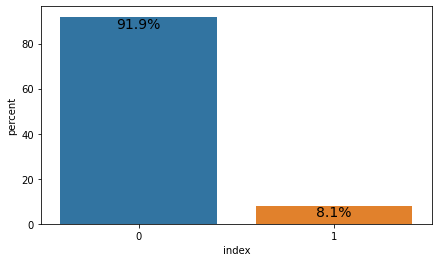

In [31]:
# we have already seen the proportion of classes from describe method of the DataFrame, column TARGET, line MEAN 


norm_target = appli_tr.TARGET.value_counts(normalize=True).mul(100).rename('percent').reset_index()

plt.figure(figsize=(7,4))
# ax = sns.barplot(x=norm_target.index, y=norm_target.values, data=norm_target)
ax = sns.barplot(x='index', y='percent', data=norm_target)

# annotate shows the values above the graphs
# in the cycle, take every bar on the graph and write the value
for patch in ax.patches:
    percentage= '{:.1f}%'.format(patch.get_height())
    ax.annotate(percentage, # text
    (patch.get_x() + patch.get_width() / 2, patch.get_height()), # set x and y for the annotation
    ha='center',
    va='top',
#     xytext=(0, 10), # with this line all the annotations are located in the same area, signatures overlap
#     textcoords='offset_points', # shift from the coordinate
    fontsize=14)

DAYS_EMPLOYED: How many days before the application the person started current employment

### CNT_CHILDREN (with impact of CNT_FAM_MEMBERS, CODE_GENDER and DAYS_BIRTH)

In [32]:
# find_most_risky('CNT_CHILDREN', selectcol) 
# find_most_risky('CNT_FAM_MEMBERS', selectcol)
# # # # selectcol['CNT_ADULTS'] = selectcol.CNT_FAM_MEMBERS - selectcol.CNT_CHILDREN
# # # # find_most_risky('CNT_ADULTS', selectcol, show=False)

- CNT_CHILDREN: weak linear correlation up to 4 children. Outbreaks at 4 and 6. If we count "more than 6" as 1 category, the default rate is about 10%. Worth comparing with this feature and without. __UPD: can drop__
- CNT_FAM_MEMBERS: the same linear correlation that was observed for CNT_CHILDREN is broken between 1 and 2, because 2 FAM_MEMBERS have low fail rate than 1. So it makes even less sense to include it. DROP
- CNT_ADULTS: synthetic variable has only values 1 or 2, and no difference in fail rate. DROP

In [33]:
# appli_tr[appli_tr.CNT_FAM_MEMBERS.isna()].CNT_CHILDREN # both 0
appli_tr['CNT_FAM_MEMBERS'] = appli_tr.CNT_FAM_MEMBERS.fillna(appli_tr.CNT_CHILDREN + 1).astype('int64')

In [34]:
# how many children has a single parent (or just a single person, not a parent)
display(appli_tr[appli_tr.CNT_FAM_MEMBERS == appli_tr.CNT_CHILDREN + 1].CNT_CHILDREN.value_counts())
# how many adults are considered to be a family? grandparents, siblings, are they taken into account?
(appli_tr.CNT_FAM_MEMBERS - appli_tr.CNT_CHILDREN).value_counts(dropna=False) 

0     67849
1     10835
2      2317
3       265
4        26
5         5
6         2
19        2
9         1
14        1
7         1
Name: CNT_CHILDREN, dtype: int64

2    226207
1     81304
dtype: int64

In [35]:
appli_tr[(appli_tr.CNT_FAM_MEMBERS == appli_tr.CNT_CHILDREN + 1) & 
         (appli_tr.CNT_CHILDREN > 2)].TARGET.mean() * 100
# being a single parent with 3 children doesn't rises the probability of a credit fail, compare to total mean 8.1

11.55115511551155

In [36]:
# sns.displot(data=appli_tr, x='CNT_FAM_MEMBERS', hue='TARGET', kind='kde', common_norm=False, bw_adjust=1.8) 
# sns.displot(data=appli_tr, x='CNT_CHILDREN', hue='TARGET', kind='kde', common_norm=False, bw_adjust=1.8)

# I should find an easier readable graph, without these sharp peaks

In [37]:
# appli_tr['CNT_ADULTS'] = appli_tr.CNT_FAM_MEMBERS - appli_tr.CNT_CHILDREN
# sns.displot(data=appli_tr, x='CNT_CHILDREN', hue='TARGET', col='CNT_ADULTS', kind='kde', common_norm=False)
# not an informative graph: sharp peaks, and I can't see whether any difference in heigth

In [38]:
# appli_tr['SINGLE_PARENT_CNT_CHILDREN'] = np.where(appli_tr.CNT_FAM_MEMBERS == appli_tr.CNT_CHILDREN + 1, appli_tr.CNT_CHILDREN, 0)
# appli_tr['DOUBLE_PARENT_CNT_CHILDREN'] = np.where(appli_tr.CNT_FAM_MEMBERS == appli_tr.CNT_CHILDREN + 2, appli_tr.CNT_CHILDREN, 0)

# similar to 'AGE_F' vs 'AGE_M' (see below), but I should find an easier readable graph, without these sharp peaks

### DAYS_BIRTH (with impact of CODE_GENDER)

<AxesSubplot:>

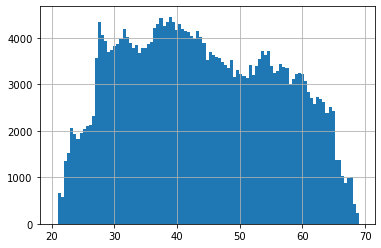

In [39]:
# display(appli_tr.DAYS_BIRTH.hist()) # negative values
appli_tr['DAYS_BIRTH'] = appli_tr.DAYS_BIRTH.abs() + 1
appli_tr['YEARS_BIRTH'] = appli_tr.DAYS_BIRTH / 365.25
display(appli_tr.YEARS_BIRTH.hist(bins=99)) # How many days before the application the person started current employment

In [40]:
display(appli_tr.groupby('TARGET')['YEARS_BIRTH'].mean())
display(appli_tr.groupby('TARGET')['YEARS_BIRTH'].median())

# the mode of age, the most frequent age
# appli_tr.groupby('TARGET')['YEARS_BIRTH'].transform(lambda x: x.value_counts().index[0] )
display(appli_tr.groupby('TARGET')['YEARS_BIRTH'].apply(lambda x: x.round().value_counts().index[0]))

# if use transform instead of apply, it wil return the series, not the mode of every group
# maybe apply acts on Series or on part of Series formed after groupby, while transform acts elementwise
# appli_tr.groupby('TARGET')['YEARS_BIRTH'].transform(lambda x: x.round().value_counts().index[0])

TARGET
0    44.186657
1    40.755176
Name: YEARS_BIRTH, dtype: float64

TARGET
0    43.471595
1    39.104723
Name: YEARS_BIRTH, dtype: float64

TARGET
0    39.0
1    28.0
Name: YEARS_BIRTH, dtype: float64

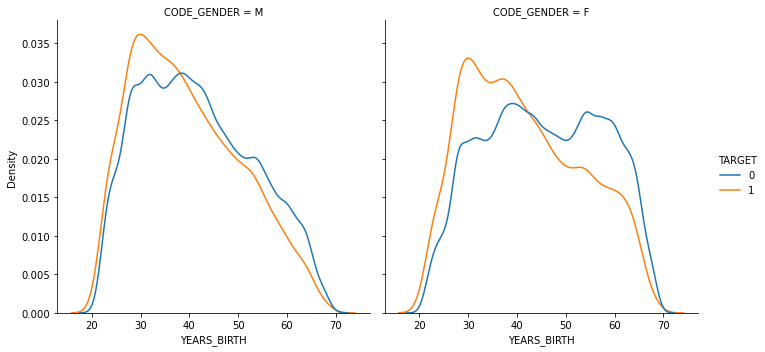

In [41]:
sns.displot(data=appli_tr, x='YEARS_BIRTH', hue='TARGET', col='CODE_GENDER', kind='kde', common_norm=False)

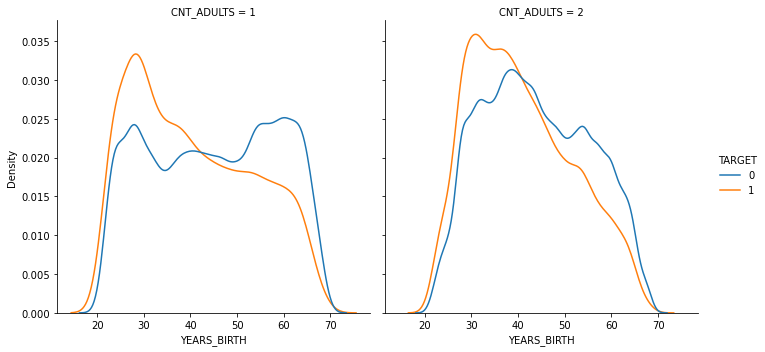

In [42]:
appli_tr['CNT_ADULTS'] = appli_tr.CNT_FAM_MEMBERS - appli_tr.CNT_CHILDREN
sns.displot(data=appli_tr, x='YEARS_BIRTH', hue='TARGET', col='CNT_ADULTS', kind='kde', common_norm=False)
# the peak for old single adult should correspond to the widow family status

In [43]:
appli_tr['F_AGE'] = np.where(appli_tr.CODE_GENDER == 'F', appli_tr.DAYS_BIRTH, 0)
appli_tr['M_AGE'] = np.where(appli_tr.CODE_GENDER == 'M', appli_tr.DAYS_BIRTH, 0)

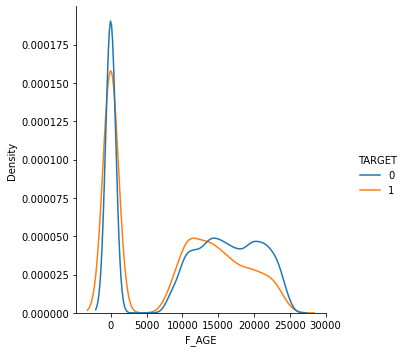

In [44]:
sns.displot(data=appli_tr, x='F_AGE', hue='TARGET', kind='kde', common_norm=False)

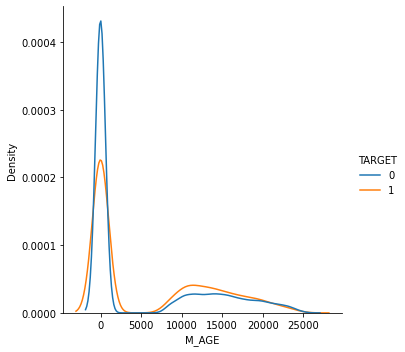

In [45]:
sns.displot(data=appli_tr, x='M_AGE', hue='TARGET', kind='kde', common_norm=False)

###  DAYS_EMPLOYED (with impact of DAYS_BIRTH and CODE_GENDER)

365243    55374
Name: DAYS_EMPLOYED, dtype: int64

<AxesSubplot:>

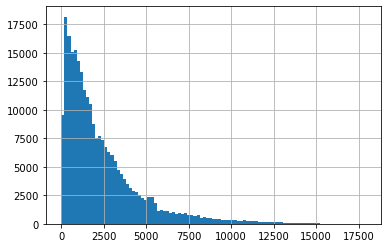

In [46]:
# display(appli_tr.DAYS_EMPLOYED.hist()) # a peak around 350,000
display(appli_tr.loc[appli_tr.DAYS_EMPLOYED > 50_000, 'DAYS_EMPLOYED'].value_counts(dropna=False)) #365243 is 1,000 years

appli_tr.loc[appli_tr.DAYS_EMPLOYED > 50_000, 'DAYS_EMPLOYED'] = np.nan # 50,000 days is 136.89 years
# appli_tr.replace(365243, np.nan, inplace=True) # works as well
appli_tr['DAYS_EMPLOYED'] = appli_tr.DAYS_EMPLOYED.abs() + 1

display(appli_tr.DAYS_EMPLOYED.hist(bins=99)) # How many days before the application the person started current employment

In [47]:
print(appli_tr.TARGET.mean() * 100)
print(appli_tr[appli_tr.DAYS_EMPLOYED.isna()].TARGET.mean() * 100)
print(appli_tr.DAYS_EMPLOYED.mean())
print(appli_tr.DAYS_EMPLOYED.median())
print(appli_tr.DAYS_EMPLOYED.value_counts().index[0])

display(appli_tr.groupby('TARGET')['DAYS_EMPLOYED'].apply(lambda x: x.round().value_counts().index[0]))

8.072881945686495
5.399646043269405
2385.1693246132063
1649.0
201.0


TARGET
0    225.0
1    235.0
Name: DAYS_EMPLOYED, dtype: float64

<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='Density'>

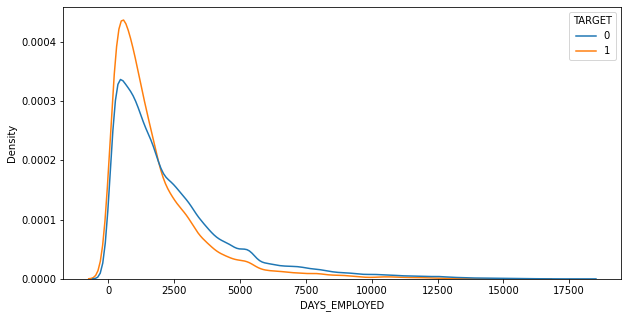

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(ax=ax, data=appli_tr, x='DAYS_EMPLOYED', hue='TARGET', common_norm=False)

In [49]:
# # # appli_tr['TEST_EMPLOYED0'] = appli_tr.DAYS_EMPLOYED.fillna(1)
# # # appli_tr['TEST_EMPLOYED1'] = appli_tr.DAYS_EMPLOYED.fillna(appli_tr.DAYS_EMPLOYED.value_counts().index[0])
# # # appli_tr['TEST_EMPLOYED2'] = appli_tr.DAYS_EMPLOYED.fillna(appli_tr.DAYS_EMPLOYED.median())
# # # appli_tr['TEST_EMPLOYED3'] = appli_tr.DAYS_EMPLOYED.fillna(appli_tr.DAYS_EMPLOYED.mean())

# # # fig, ax = plt.subplots(figsize=(10, 5))
# # # display(sns.kdeplot(ax=ax, data=appli_tr, x='TEST_EMPLOYED0', hue='TARGET', common_norm=False))
# # # display(sns.kdeplot(ax=ax, data=appli_tr, x='TEST_EMPLOYED1', hue='TARGET', common_norm=False))
# # # display(sns.kdeplot(ax=ax, data=appli_tr, x='TEST_EMPLOYED2', hue='TARGET', common_norm=False))
# # # display(sns.kdeplot(ax=ax, data=appli_tr, x='TEST_EMPLOYED3', hue='TARGET', common_norm=False))

appli_tr['DAYS_EMPLOYED'] = appli_tr.DAYS_EMPLOYED.fillna(appli_tr.DAYS_EMPLOYED.mean())
appli_tr['YEARS_EMPLOYED'] = appli_tr.DAYS_EMPLOYED / 365.25

In [50]:
appli_ok = appli_tr[appli_tr.TARGET== 0]
appli_fail = appli_tr[appli_tr.TARGET== 1]

Text(0.5, 6.79999999999999, 'Age, years')

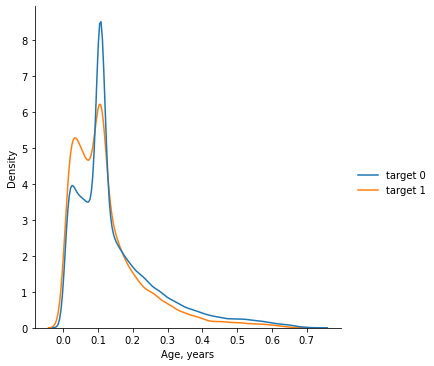

In [51]:
sns.displot(
{   'target 0': appli_ok.YEARS_EMPLOYED / appli_ok.YEARS_BIRTH,
    'target 1': appli_fail.YEARS_EMPLOYED / appli_fail.YEARS_BIRTH 
}, kind='kde', common_norm=False)
plt.xlabel('Age, years')

Text(0.5, 6.79999999999999, 'Age, years')

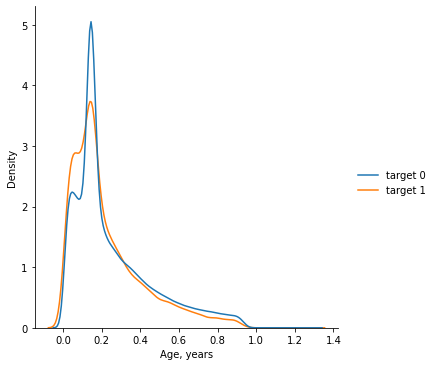

In [52]:
# the difference between target 0 and target 1 seems to be less pronounced 
sns.displot(
{   'target 0': appli_ok.YEARS_EMPLOYED / (appli_ok.YEARS_BIRTH - 16),
    'target 1': appli_fail.YEARS_EMPLOYED / (appli_fail.YEARS_BIRTH - 16) 
}, kind='kde', common_norm=False)
plt.xlabel('Age, years')

# makes no sense to create synthetic variable DAYS_EMPLOYED / (DAYS_BIRTH - 5844) where 5844 days is 16 years

I tested the synthetic features DAYS_EMPLOYED_PERC = DAYS_EMPLOYED / DAYS_BIRTH and DAYS_EMPLOYED_ADULT = DAYS_EMPLOYED / (DAYS_BIRTH - 5844) where 5844 days is 16 years. I tested the model with all these variables included.

Later at the Shap verification of feature importances, I saw that the variables DAYS_EMPLOYED, DAYS_EMPLOYED_PERC and DAYS_EMPLOYED_ADULT are highly correlated (which is quite expected). That's why I can keep only one of these variables, and thus reduce the bad effect of the correlation.
I will keep the proportion DAYS_EMPLOYED / DAYS_BIRTH, because it shows good distinction between the target curves, and doesn't have such a long trailing tail as original DAYS_EMPLOYED variable.


In [53]:
appli_tr['DAYS_EMPLOYED_PERC'] = appli_tr['DAYS_EMPLOYED'] / appli_tr['DAYS_BIRTH']

###  DAYS_ID_PUBLISH (with impact of DAYS_BIRTH and CODE_GENDER)

<AxesSubplot:>

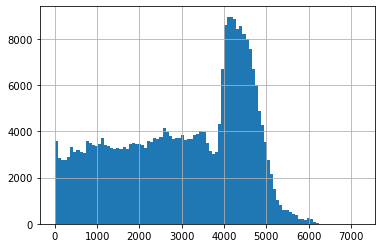

In [54]:
# display(appli_tr.DAYS_ID_PUBLISH.hist()) # negative values
appli_tr['DAYS_ID_PUBLISH'] = appli_tr.DAYS_ID_PUBLISH.abs() + 1
display(appli_tr.DAYS_ID_PUBLISH.hist(bins=99)) # How many days before the application the person started current employment

In [55]:
display(appli_tr.groupby('TARGET')['DAYS_ID_PUBLISH'].apply(lambda x: x.round().value_counts().index[0]))
display(appli_tr.groupby('TARGET')['DAYS_ID_PUBLISH'].apply(lambda x: x.median()))
display(appli_tr.groupby('TARGET')['DAYS_ID_PUBLISH'].apply(lambda x: x.mean()))

TARGET
0    4054
1    4034
Name: DAYS_ID_PUBLISH, dtype: int64

TARGET
0    3296.0
1    2798.0
Name: DAYS_ID_PUBLISH, dtype: float64

TARGET
0    3018.219788
1    2733.099617
Name: DAYS_ID_PUBLISH, dtype: float64

<AxesSubplot:xlabel='DAYS_ID_PUBLISH', ylabel='Density'>

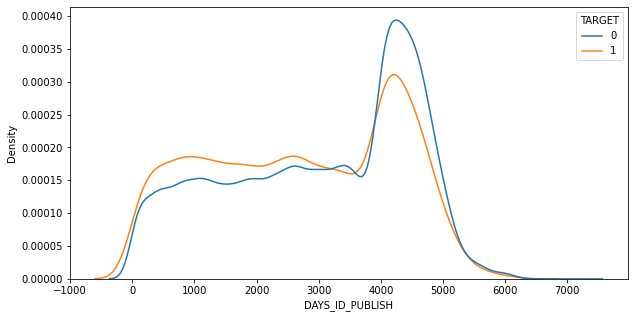

In [56]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(ax=ax, data=appli_tr, x='DAYS_ID_PUBLISH', hue='TARGET', common_norm=False)

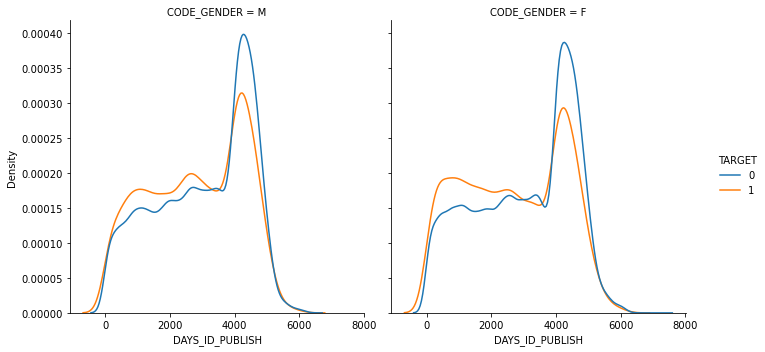

In [57]:
sns.displot(data=appli_tr, x='DAYS_ID_PUBLISH', col='CODE_GENDER', hue='TARGET', kind='kde', common_norm=False)

###  DAYS_REGISTRATION (with impact of DAYS_BIRTH and CODE_GENDER)

<AxesSubplot:>

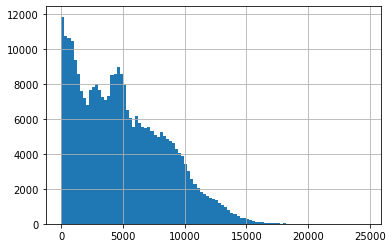

In [72]:
# display(appli_tr.DAYS_REGISTRATION.hist()) # negative values
appli_tr['DAYS_REGISTRATION'] = appli_tr.DAYS_REGISTRATION.abs() + 1
display(appli_tr.DAYS_REGISTRATION.hist(bins=99)) # How many days before the application the person started current employment

In [73]:
display(appli_tr.groupby('TARGET')['DAYS_REGISTRATION'].apply(lambda x: x.round().value_counts().index[0]))
display(appli_tr.groupby('TARGET')['DAYS_REGISTRATION'].apply(lambda x: x.median()))
display(appli_tr.groupby('TARGET')['DAYS_REGISTRATION'].apply(lambda x: x.mean()))

TARGET
0    2.0
1    2.0
Name: DAYS_REGISTRATION, dtype: float64

TARGET
0    4545.0
1    4057.0
Name: DAYS_REGISTRATION, dtype: float64

TARGET
0    5030.941065
1    4488.127009
Name: DAYS_REGISTRATION, dtype: float64

<AxesSubplot:xlabel='DAYS_REGISTRATION', ylabel='Density'>

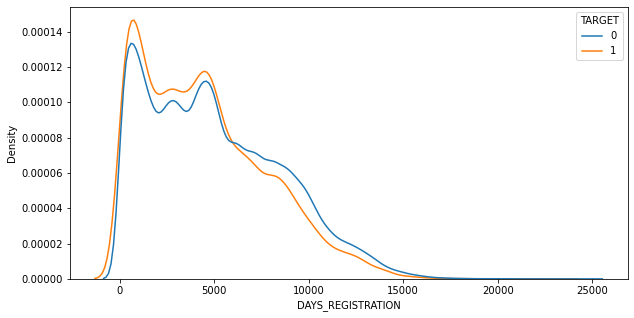

In [74]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(ax=ax, data=appli_tr, x='DAYS_REGISTRATION', hue='TARGET', common_norm=False)

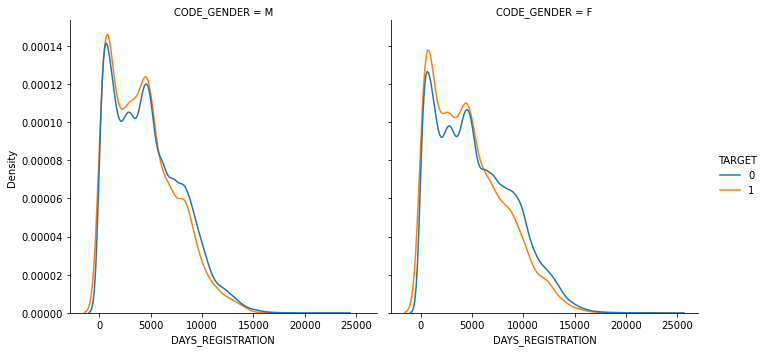

In [75]:
sns.displot(data=appli_tr, x='DAYS_REGISTRATION', col='CODE_GENDER', hue='TARGET', kind='kde', common_norm=False)

### HOUR_APPR_PROCESS_START

In [58]:
# find_most_risky('HOUR_APPR_PROCESS_START', selectcol)

- HOUR_APPR_PROCESS_START: there is a correlation, but not linear. People who apply at night or early morning (10PM-7AM) fail their credits more often.
But to transfer this 'circular' dependence into a linear one, we should 'shift the clock'. So that the night starts at 22 hours, not at 0 hours.

In [59]:
appli_tr.loc[appli_tr.HOUR_APPR_PROCESS_START > 21, 'HOUR_APPR_PROCESS_START'] = appli_tr.HOUR_APPR_PROCESS_START - 24
appli_tr['HOUR_APPR_PROCESS_START'] = appli_tr.HOUR_APPR_PROCESS_START + 2

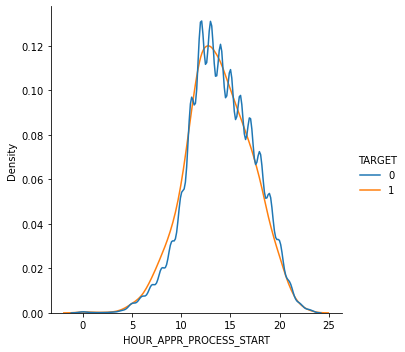

In [77]:
sns.displot(data=appli_tr, x='HOUR_APPR_PROCESS_START', hue='TARGET', kind='kde', common_norm=False, bw_adjust=1.7)
# The graph still looks like the difference on the graphs is tiny. Maybe I will remove this feture at the final cleaning step.

## Float variables: analysis, feature selection, imputing values

In [76]:
# appli_tr.describe() # 106 columns, hard to follow
test = appli_tr.describe(include=float).transpose()
# test['missing'] = (test['count'] / appli_tr.shape[0] * 100).transform(round) # transform(round(3)) raises an error
test['missing'] = ((1-test['count'] / appli_tr.shape[0]) * 100).transform(lambda x: x.round(3))
test['count'] = appli_tr.shape[0] - test['count']

display(test[:11])
# display(test[-15:])
print(test.shape[0])

,count,mean,std,min,25%,50%,75%,max,missing
AMT_INCOME_TOTAL,0.0,168797.919297,237123.146279,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08,0.000
AMT_CREDIT,0.0,599025.999706,402490.776996,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06,0.000
AMT_ANNUITY,12.0,27108.573909,14493.737315,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05,0.004
AMT_GOODS_PRICE,278.0,538396.207429,369446.460540,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06,0.090
REGION_POPULATION_RELATIVE,0.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02,0.000
DAYS_EMPLOYED,0.0,2385.169325,2117.381973,1.000000e+00,934.000000,2220.000000,2761.000000,1.791300e+04,0.000
DAYS_REGISTRATION,0.0,4987.120328,3522.886321,1.000000e+00,2011.000000,4505.000000,7480.500000,2.467300e+04,0.000
OWN_CAR_AGE,202929.0,12.061091,11.944812,0.000000e+00,5.000000,9.000000,15.000000,9.100000e+01,65.991
EXT_SOURCE_1,173378.0,0.502130,0.211062,1.456813e-02,0.334007,0.505998,0.675053,9.626928e-01,56.381
EXT_SOURCE_2,660.0,0.514393,0.191060,8.173617e-08,0.392457,0.565961,0.663617,8.549997e-01,0.215


68


OWN_CAR_AGE, EXT_SOURCE_1, have more than half values NaNs. EXT_SOURCE_3 has 20% NaNs.

<AxesSubplot:>

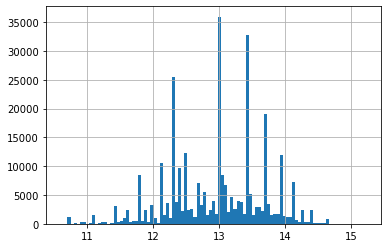

In [87]:
# appli_tr.AMT_INCOME_TOTAL.hist(bins=99) # exponential distribution
# appli_tr.AMT_ANNUITY.hist(bins=99) # exponential distribution
# appli_tr.AMT_CREDIT.hist(bins=99) # biased distribution 
# np.log(appli_tr.AMT_CREDIT).hist(bins=99) # not a normal distribution, but less skewed, almost symmetric 
# appli_tr.AMT_GOODS_PRICE.hist(bins=20) # biased distribution
np.log(appli_tr.AMT_GOODS_PRICE).hist(bins=99) # not a normal distribution, but less skewed, almost symmetric 
# appli_tr.REGION_POPULATION_RELATIVE.hist(bins=20) # biased distribution
# appli_tr.OWN_CAR_AGE.hist(bins=20) # strongly skewed, biased distribution.


__HOW TO USE THE GRAPHIC CELLS: IF YOU WANT TO SEE CERTAIN GRAPHIC? UNCOMMENT THE WHOLE CELL.__

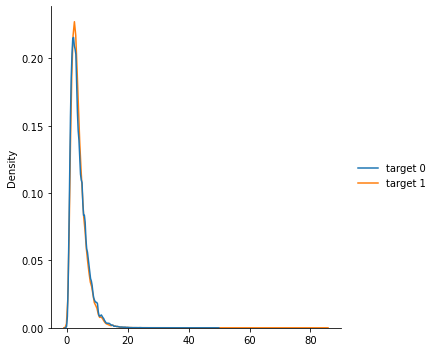

In [81]:
# sns.displot({'target 0': appli_ok.AMT_CREDIT / appli_ok.AMT_INCOME_TOTAL,
#     'target 1': appli_fail.AMT_CREDIT / appli_fail.AMT_INCOME_TOTAL},
#     kind='kde', common_norm=False) 

# # graphs go aligned, very skewed graph. Logarithmization is needed

In [82]:
appli_tr['AMT_INCOME_TOTAL'] = np.log(appli_tr.AMT_INCOME_TOTAL)
appli_tr['AMT_CREDIT'] = np.log(appli_tr.AMT_CREDIT)

appli_tr['AMT_ANNUITY'] = np.log(appli_tr.AMT_ANNUITY)
appli_tr['AMT_GOODS_PRICE'] = np.log(appli_tr.AMT_GOODS_PRICE)


<AxesSubplot:xlabel='AMT_GOODS_PRICE', ylabel='Density'>

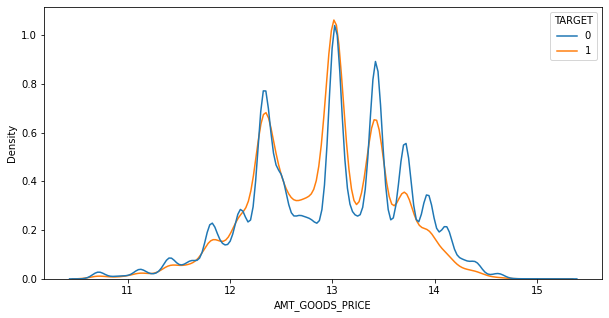

In [105]:
fig, ax = plt.subplots(figsize=(10, 5))

# sns.kdeplot(ax=ax, data=appli_tr, x='AMT_INCOME_TOTAL', hue='TARGET', common_norm=False)
# # no difference, just the sharpness

# sns.kdeplot(ax=ax, data=appli_tr, x='AMT_CREDIT', hue='TARGET', common_norm=False)
# # certainly different curves. more fails between 12.5 and 13.5

# sns.kdeplot(ax=ax, data=appli_tr, x='AMT_ANNUITY', hue='TARGET', common_norm=False)
# # slightly different curves. more fails between 10 and 10.5

sns.kdeplot(ax=ax, data=appli_tr, x='AMT_GOODS_PRICE', hue='TARGET', common_norm=False)
# certainly different curves. more fails around 13


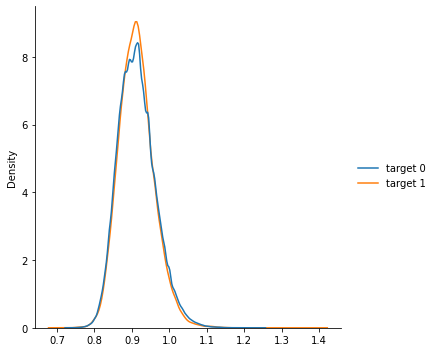

In [107]:
appli_ok = appli_tr[appli_tr.TARGET== 0]
appli_fail = appli_tr[appli_tr.TARGET== 1]

# sns.displot({'target 0': appli_ok.AMT_INCOME_TOTAL / appli_ok.AMT_CREDIT,
#     'target 1': appli_fail.AMT_INCOME_TOTAL / appli_fail.AMT_CREDIT},
#     kind='kde', common_norm=False)

# # graphics go aligned except the region 0.8-0.9.

# sns.displot({'target 0': appli_ok.AMT_INCOME_TOTAL / appli_ok.AMT_ANNUITY,
#     'target 1': appli_fail.AMT_INCOME_TOTAL / appli_fail.AMT_ANNUITY},
#     kind='kde', common_norm=False)


# # # graphics go aligned except the region 0.8-0.9. overall, there is no difference

In [102]:
appli_ok = appli_tr[appli_tr.TARGET== 0]
appli_fail = appli_tr[appli_tr.TARGET== 1]

# sns.displot({'target 0': appli_ok.AMT_CREDIT / appli_ok.AMT_INCOME_TOTAL,
#     'target 1': appli_fail.AMT_CREDIT / appli_fail.AMT_INCOME_TOTAL},
#     kind='kde', common_norm=False)

# # graphics go aligned except the region 1.0-1.2

# sns.displot({'target 0': appli_ok.AMT_ANNUITY / appli_ok.AMT_INCOME_TOTAL,
#     'target 1': appli_fail.AMT_ANNUITY / appli_fail.AMT_INCOME_TOTAL},
#     kind='kde', common_norm=False)


# # graphics go aligned except the region 0.8-0.9. overall, the difference is tiny

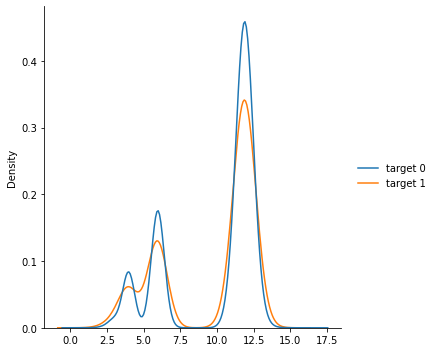

In [97]:
appli_ok = appli_tr[appli_tr.TARGET== 0]
appli_fail = appli_tr[appli_tr.TARGET== 1]

# # # the shapes of the graphs for 0 and for 1 are quite similar, just the value fluctuations are not so sharp.
# sns.displot({'target 0': appli_ok.AMT_INCOME_TOTAL / appli_ok.CNT_FAM_MEMBERS,
#     'target 1': appli_fail.AMT_INCOME_TOTAL / appli_fail.CNT_FAM_MEMBERS},
#     kind='kde', common_norm=False, bw_adjust=1.5)

# # with the variable 'children' it's more complicated, because one should divide by zero and take a log of zero
# # seaborn still does it though. but I guess the graphs are not precise

# # # # the shapes of the graphs for 0 and for 1 are quite similar, just the value fluctuations are not so sharp.
# sns.displot({'target 0': appli_ok.AMT_INCOME_TOTAL / (appli_ok.CNT_CHILDREN+1),
#     'target 1': appli_fail.AMT_INCOME_TOTAL / (appli_fail.CNT_CHILDREN+1)},
#     kind='kde', common_norm=False, bw_adjust=1.5)

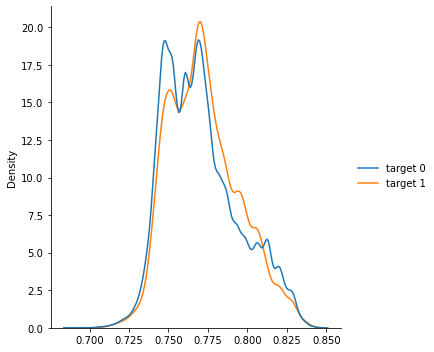

In [104]:
# sns.displot({'target 0': (appli_ok.AMT_ANNUITY / appli_ok.AMT_CREDIT),
#     'target 1': appli_fail.AMT_ANNUITY / appli_fail.AMT_CREDIT},
#     kind='kde', common_norm=False)

# # # the graphs are different, but less different than the source variables

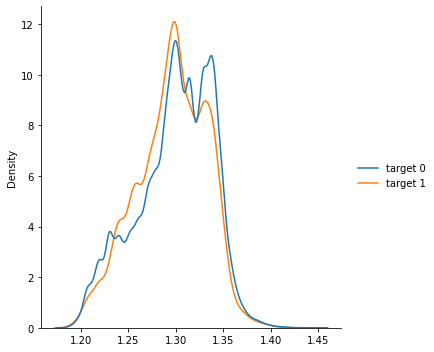

In [106]:
sns.displot({'target 0': (appli_ok.AMT_CREDIT / appli_ok.AMT_ANNUITY),
    'target 1': appli_fail.AMT_CREDIT / appli_fail.AMT_ANNUITY},
    kind='kde', common_norm=False)

# here we see quite a good tendency: target 1 is higher at 1.2-1.3, tarket 0 is higher at 1.3-1.4

Below is the list of external source kernel variables, feature engineering.

Only the last feature from the offered external source kernel looks promising - I see some differences on histograms.

In [ ]:
# appli_tr['INCOME_CREDIT_PERC'] = appli_tr['AMT_INCOME_TOTAL'] / appli_tr['AMT_CREDIT'] # doesn't seem a good feature according kde plots.
# appli_tr['INCOME_PER_PERSON'] = appli_tr['AMT_INCOME_TOTAL'] / appli_tr['CNT_FAM_MEMBERS'] # not a good feature according kde plots.
# appli_tr['ANNUITY_INCOME_PERC'] = appli_tr['AMT_ANNUITY'] / appli_tr['AMT_INCOME_TOTAL'] # the difference is only because of the difference in the annuities
# appli_tr['PAYMENT_RATE'] = appli_tr['AMT_ANNUITY'] / appli_tr['AMT_CREDIT'] # rather good feature, but the inverse is better, AMT_CREDIT / AMT_ANNUITY
# better to inverse it and call 'the credit duration'

In [ ]:
appli_tr['AMT_ANNUITY'] = appli_tr.AMT_ANNUITY.fillna(appli_tr.AMT_ANNUITY.median())
appli_tr['AMT_GOODS_PRICE'] = appli_tr.AMT_GOODS_PRICE.fillna(appli_tr.AMT_GOODS_PRICE.median())

print(appli_tr[appli_tr.DAYS_REGISTRATION != appli_tr.DAYS_REGISTRATION.transform(int)]['DAYS_REGISTRATION'])
appli_tr['DAYS_REGISTRATION'] = appli_tr.DAYS_REGISTRATION.transform('int64')

In [ ]:
appli_tr['PAYMENT_RATE'] = appli_tr['AMT_ANNUITY'] / appli_tr['AMT_CREDIT']
appli_tr['CREDIT TERM'] = appli_tr['AMT_CREDIT'] / appli_tr['AMT_ANNUITY']
# appli_tr['CNT_ADULTS'] = appli_tr.CNT_FAM_MEMBERS - appli_tr.CNT_CHILDREN

I stopped here.

<AxesSubplot:xlabel='OWN_CAR_AGE', ylabel='Density'>

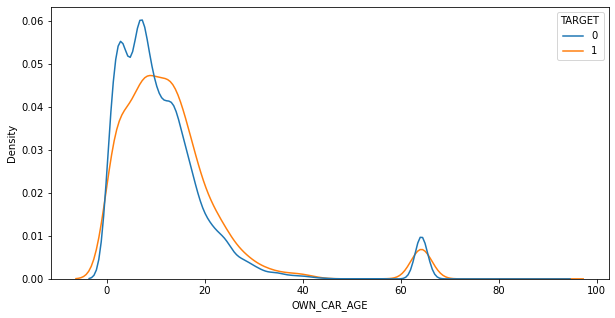

In [109]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(ax=ax, data=appli_tr, x='OWN_CAR_AGE', hue='TARGET', common_norm=False)
# in general the age of the target1 curve is higher than that of target 0 curve

### Variables 'external source', how to impute

In [ ]:
# How many are failers
print(appli_tr.TARGET.mean() * 100)
print()
# Given that the EXT_SOURCE is filled or NaN what is the chance to find a failer
print(appli_tr[appli_tr.EXT_SOURCE_1.notna()].TARGET.mean() * 100)
print(appli_tr[appli_tr.EXT_SOURCE_1.isna()].TARGET.mean() * 100)
print()
print(appli_tr[appli_tr.EXT_SOURCE_2.notna()].TARGET.mean() * 100)
print(appli_tr[appli_tr.EXT_SOURCE_2.isna()].TARGET.mean() * 100)
print()
print(appli_tr[appli_tr.EXT_SOURCE_3.notna()].TARGET.mean() * 100)
print(appli_tr[appli_tr.EXT_SOURCE_3.isna()].TARGET.mean() * 100)

There is some difference in failure rating between the clients with known values and NaNs, but not large one.
Lack of source1 increase the fail risk 1.13 times, lack of source 2 decreases the fail risk 0.97 times, lack of source 3 increases the risk 1.19 times.

What is the proportion of NaN for the failers and for the ok clients?

In [ ]:
# test= appli_tr.EXT_SOURCE_1.mode()
# appli_tr.EXT_SOURCE_1.mode()[len(appli_tr.EXT_SOURCE_1.mode()) // 2]

print(appli_tr.EXT_SOURCE_1.mode()[len(appli_tr.EXT_SOURCE_1.mode()) // 2])
print(appli_tr.EXT_SOURCE_1.median() * 100)
print(appli_tr.EXT_SOURCE_1.mean() * 100)
print()
print(appli_ok.EXT_SOURCE_1.mode()[len(appli_ok.EXT_SOURCE_1.mode()) // 2])
print(appli_ok.EXT_SOURCE_1.median() * 100)
print(appli_ok.EXT_SOURCE_1.mean() * 100)
print()
print(appli_fail.EXT_SOURCE_1.mode()[len(appli_fail.EXT_SOURCE_1.mode()) // 2])
print(appli_fail.EXT_SOURCE_1.median() * 100)
print(appli_fail.EXT_SOURCE_1.mean() * 100)

For the missing values in the source 1 a compromise solution is to fill the missing values by mean, which is the closest to the median and the mean of failers. Same thing for source 2 and source 3 (see graphs below).

In [ ]:
appli_tr['EXT_SOURCE_1'] = appli_tr.EXT_SOURCE_1.fillna(appli_tr.EXT_SOURCE_1.mean())

In [ ]:
# test= appli_tr.EXT_SOURCE_2.mode()
# appli_tr.EXT_SOURCE_2.mode()[len(appli_tr.EXT_SOURCE_2.mode()) // 2]

print(appli_tr.EXT_SOURCE_2.mode()[len(appli_tr.EXT_SOURCE_2.mode()) // 2])
print(appli_tr.EXT_SOURCE_2.median() * 100)
print(appli_tr.EXT_SOURCE_2.mean() * 100)
print()
print(appli_ok.EXT_SOURCE_2.mode()[len(appli_ok.EXT_SOURCE_2.mode()) // 2])
print(appli_ok.EXT_SOURCE_2.median() * 100)
print(appli_ok.EXT_SOURCE_2.mean() * 100)
print()
print(appli_fail.EXT_SOURCE_2.mode()[len(appli_fail.EXT_SOURCE_2.mode()) // 2])
print(appli_fail.EXT_SOURCE_2.median() * 100)
print(appli_fail.EXT_SOURCE_2.mean() * 100)

In [ ]:
appli_tr.EXT_SOURCE_2.mode()

In [ ]:
appli_tr.EXT_SOURCE_2.hist(bins=50)

In [ ]:
appli_tr['EXT_SOURCE_2'] = appli_tr.EXT_SOURCE_2.fillna(appli_tr.EXT_SOURCE_2.mode()[len(appli_tr.EXT_SOURCE_2.mode()) // 2])

In [ ]:
# test= appli_tr.EXT_SOURCE_3.mode()
# appli_tr.EXT_SOURCE_3.mode()[len(appli_tr.EXT_SOURCE_3.mode()) // 2]

print(appli_tr.EXT_SOURCE_3.mode()[len(appli_tr.EXT_SOURCE_3.mode()) // 2])
print(appli_tr.EXT_SOURCE_3.median() * 100)
print(appli_tr.EXT_SOURCE_3.mean() * 100)
print()
print(appli_ok.EXT_SOURCE_3.mode()[len(appli_ok.EXT_SOURCE_3.mode()) // 2])
print(appli_ok.EXT_SOURCE_3.median() * 100)
print(appli_ok.EXT_SOURCE_3.mean() * 100)
print()
print(appli_fail.EXT_SOURCE_3.mode()[len(appli_fail.EXT_SOURCE_3.mode()) // 2])
print(appli_fail.EXT_SOURCE_3.median() * 100)
print(appli_fail.EXT_SOURCE_3.mean() * 100)

In [ ]:
appli_tr.EXT_SOURCE_3.mode()

In [ ]:
appli_tr.EXT_SOURCE_3.hist(bins=50)

In [ ]:
appli_tr['EXT_SOURCE_3'] = appli_tr.EXT_SOURCE_3.fillna(appli_tr.EXT_SOURCE_3.mean())

In [ ]:
display(appli_tr.TOTALAREA_MODE.hist(bins=50))
print(appli_tr.TOTALAREA_MODE.min())
print(appli_tr.TOTALAREA_MODE.max())

In [ ]:
display(appli_tr.DAYS_LAST_PHONE_CHANGE.hist(bins=50))
print(appli_tr.DAYS_LAST_PHONE_CHANGE.min())
print(appli_tr.DAYS_LAST_PHONE_CHANGE.max())
# for being able to apply the log scale:
appli_tr['DAYS_LAST_PHONE_CHANGE'] = appli_tr.DAYS_LAST_PHONE_CHANGE.abs() + 1
print(appli_tr.DAYS_LAST_PHONE_CHANGE.min())

In [ ]:
# display(appli_tr[appli_tr.TARGET == 0].DAYS_LAST_PHONE_CHANGE.hist(bins=50))
display(appli_tr[appli_tr.TARGET == 1].DAYS_LAST_PHONE_CHANGE.hist(bins=30))

In [ ]:
display(appli_tr[appli_tr.TARGET == 0].OBS_30_CNT_SOCIAL_CIRCLE.hist(bins=50))
# display(appli_tr[appli_tr.TARGET == 1].OBS_30_CNT_SOCIAL_CIRCLE.hist(bins=30))

In [ ]:
# display(appli_tr[appli_tr.TARGET == 0].AMT_REQ_CREDIT_BUREAU_YEAR.hist(bins=50))
display(appli_tr[appli_tr.TARGET == 1].AMT_REQ_CREDIT_BUREAU_YEAR.hist(bins=50))

In [ ]:
sns.displot(data=appli_tr, x='DAYS_LAST_PHONE_CHANGE', hue='TARGET', kind='kde', log_scale=True, common_norm=False)
# sns.displot(data=appli_tr, x='TOTALAREA_MODE', hue='TARGET', kind='kde', common_norm=False)


- AMT_INCOME_TOTAL: log scale needed. SURPRISINGLY NO DIFFERENCE. delete this variable? no
- AMT_CREDIT: log scale needed. different curves: more fails for mid-sized credits
- AMT_ANNUITY: somewhat hire annuities increase the odds to fail, but these differences are minor. delete this variable?
- AMT_GOODS_PRICE: log scale not required, but is better to reveal the tendency. there is a difference: people who take credits on goods of small sums have higher odds to fail. people who take high amounts, have higher odds to ok.
- REGION_POPULATION_RELATIVE: higher odds of ok for more populated areas
- DAYS_REGISTRATION : shorter registration - higher odds of fail. Minor difference, DELETE? yes
- OWN_CAR_AGE : non-linear but important dependence, see the graph
- DAYS_REGISTRATION: shorter registration - higher risk to fail
- CNT_FAM_MEMBERS: don't see the difference on the graph, but I saw linear correlation up to 8 members at flags exploring.
- EXT_SOURCE_1: LARGE DIFFERENCE! but a lot of missing numbers: 56% values are NANs.
- EXT_SOURCE_2: LARGE DIFFERENCE! and it's almost fully filled: only 660 values are missing.
- EXT_SOURCE_3: LARGE DIFFERENCE! but a lot of missing numbers: 20% values are NANs.  
...  
...
- TOTALAREA_MODE: somewhat smaller totalarea means higher odds of fail. the differences seem minor though.
- OBS_30_CNT_SOCIAL_CIRCLE and 60: angular plot, fail peak is much higher than ok peak. but when transform to log, the difference is less pronounced.
- DEF_30_CNT_SOCIAL_CIRCLE and 60: there is no difference on kde plot, but distributins on histogramms look quite different.
- DAYS_LAST_PHONE_CHANGE: there is somwhat dependance, but not linear. Negative values (negtive count of days), but some values are positive. does it mean that the client knows he is going to change a phone number soon?
- no difference. delete?
- AMT_REQ_CREDIT_BUREAU_HOUR, DAY, WEEK, MON: there is some diffrernce on kde plot, but not interesting. delete this variable?
- AMT_REQ_CREDIT_BUREAU_QRT: LARGE DIFFRERENCE! the graph is angular, but the fail peak at 0 is much higher than the
- AMT_REQ_CREDIT_BUREAU_YEAR: no difference again: kde graph is wiggly, the gistograms show similar distribution.

For OBS_SOCIAL_CIRCLE, DEF_SOCIAL_CIRCLE, AMT_REQ_CREDIT_BUREAU_HOUR and DAY the distribution is similar except that for 0 target there are few high values, while for target 1 there are not. This is most probably due to higher total number of applications with target 0, just by normal probability distribution it has a longer tail trailing.

In [ ]:
print(appli_tr[appli_tr.OBS_30_CNT_SOCIAL_CIRCLE != appli_tr.OBS_60_CNT_SOCIAL_CIRCLE].shape) # 6000 out of 307,500. 2%
print(appli_tr[appli_tr.DEF_30_CNT_SOCIAL_CIRCLE != appli_tr.DEF_60_CNT_SOCIAL_CIRCLE].shape) # 13000 out of 307,500. 4%

# appli_tr = appli_tr.drop(['OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'])
# well maybe no. maybe exactly this information is crucial.

In [ ]:
appli_tr = appli_tr.drop(['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
                         'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON'], axis=1)


In [ ]:
# sns.displot(data=appli_tr, x='AMT_INCOME_TOTAL', hue='TARGET', kind='kde', common_norm=False, bw_adjust=1.5)
# sns.displot(data=appli_tr, x='AMT_CREDIT', hue='TARGET', log_scale=True, kind='kde', common_norm=False, bw_adjust=1.5)
# sns.displot(data=appli_tr, x='AMT_ANNUITY', hue='TARGET', kind='kde', log_scale=True, common_norm=False)#, bw_adjust=1.5)
sns.displot(data=appli_tr, x='AMT_GOODS_PRICE', hue='TARGET', kind='kde', common_norm=False, bw_adjust=1.5)
# sns.displot(data=appli_tr, x='REGION_POPULATION_RELATIVE', hue='TARGET', kind='kde', common_norm=False)
# sns.displot(data=appli_tr, x='DAYS_REGISTRATION', hue='TARGET', kind='kde', common_norm=False)
sns.displot(data=appli_tr, x='OWN_CAR_AGE', hue='TARGET', kind='kde', common_norm=False)
# sns.displot(data=appli_tr, x='CNT_FAM_MEMBERS', hue='TARGET', kind='kde', common_norm=False)
# sns.displot(data=appli_tr, x='EXT_SOURCE_1', hue='TARGET', kind='kde', common_norm=False)
# sns.displot(data=appli_tr, x='EXT_SOURCE_2', hue='TARGET', kind='kde', common_norm=False)
# sns.displot(data=appli_tr, x='EXT_SOURCE_3', hue='TARGET', kind='kde', common_norm=False)

# sns.displot(data=appli_tr, x='TOTALAREA_MODE', hue='TARGET', kind='kde', common_norm=False)
# sns.displot(data=appli_tr, x='OBS_30_CNT_SOCIAL_CIRCLE', hue='TARGET', kind='kde', common_norm=False)
# sns.displot(data=appli_tr, x='OBS_60_CNT_SOCIAL_CIRCLE', hue='TARGET', kind='kde', common_norm=False)
# sns.displot(data=appli_tr, x='DAYS_LAST_PHONE_CHANGE', hue='TARGET', kind='kde', log_scale=True, common_norm=False)
# sns.displot(data=appli_tr, x='AMT_REQ_CREDIT_BUREAU_QRT', hue='TARGET', kind='kde', common_norm=False, bw_adjust=1.9)
# sns.displot(data=appli_tr, x='AMT_REQ_CREDIT_BUREAU_YEAR', hue='TARGET', kind='kde', common_norm=False, bw_adjust=1.9)


In [ ]:
appli_tr.OWN_CAR_AGE.mode()

In [ ]:
appli_tr['AMT_GOODS_PRICE'] = appli_tr.AMT_GOODS_PRICE.fillna(appli_tr.AMT_GOODS_PRICE.median())
appli_tr['OWN_CAR_AGE'] = appli_tr.OWN_CAR_AGE.fillna(appli_tr.OWN_CAR_AGE.median())
appli_tr['TOTALAREA_MODE'] = appli_tr.TOTALAREA_MODE.fillna(appli_tr.TOTALAREA_MODE.median())
appli_tr['DAYS_LAST_PHONE_CHANGE'] = appli_tr.DAYS_LAST_PHONE_CHANGE.fillna(appli_tr.DAYS_LAST_PHONE_CHANGE.median())
appli_tr['AMT_REQ_CREDIT_BUREAU_QRT'] = appli_tr.AMT_REQ_CREDIT_BUREAU_QRT.fillna(appli_tr.AMT_REQ_CREDIT_BUREAU_QRT.median())

### Float variables describing client's dwelling 

In [ ]:
# float_cols = appli_tr.select_dtypes(include=float).columns # FLAG_DOCUMENT_1 doesn't exist, not in int, float or object
# float_cols

In [ ]:
len(['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI'])

In [ ]:
appli_tr = appli_tr.drop(['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG'], axis=1)


In [ ]:
appli_tr = appli_tr.drop(['APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE'], axis=1)


In [ ]:
appli_tr = appli_tr.drop(['APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
                         
                         'TOTALAREA_MODE'], axis=1)


In [61]:
# appli_tr = appli_tr.drop(['YEARS_EMPLOYED', 'YEARS_BIRTH'], axis=1)
# appli_tr = appli_tr.drop(['CODE_GENDER', 'DAYS_BIRTH'], axis=1)
# appli_tr = appli_tr.drop('DAYS_EMPLOYED', axis=1)
# appli_tr = appli_tr.drop('HOUR_APPR_PROCESS_START', axis=1)
# appli_tr = appli_tr.drop('CNT_CHILDREN', axis=1)

In [ ]:
# after the belowmentioned kind of test on all the following columns they were converted to int type:
# appli_tr[appli_tr.OWN_CAR_AGE != appli_tr.OWN_CAR_AGE.transform(int)]['OWN_CAR_AGE']


for col in ['CNT_FAM_MEMBERS', 'OWN_CAR_AGE', 'DAYS_LAST_PHONE_CHANGE',
            'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
           'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
           'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
           'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 
            'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']:
    appli_tr[col] = appli_tr[col].fillna(appli_tr[col].median())#.astype(int)

# Conversion of some categorical features to numeric ones

In [ ]:
selectcol = appli_tr.select_dtypes(include='object')
selectcol_full = selectcol.fillna('unknown')
selectcol_full['SK_ID_CURR'] = appli_tr['SK_ID_CURR']
selectcol_full['TARGET'] = appli_tr['TARGET']

# appli_tr['OCCUPATION_TYPE'] = category_to_fail_proportion(selectcol_full, 'OCCUPATION_TYPE')
# appli_tr['ORGANIZATION_TYPE'] = category_to_fail_proportion(selectcol_full, 'ORGANIZATION_TYPE')

appli_tr['NAME_TYPE_SUITE'] = category_to_fail_proportion(selectcol_full, 'NAME_TYPE_SUITE')
appli_tr['NAME_HOUSING_TYPE'] = category_to_fail_proportion(selectcol_full, 'NAME_HOUSING_TYPE')
appli_tr['FONDKAPREMONT_MODE'] = category_to_fail_proportion(selectcol_full, 'FONDKAPREMONT_MODE')
appli_tr['HOUSETYPE_MODE'] = category_to_fail_proportion(selectcol_full, 'HOUSETYPE_MODE')
appli_tr['WALLSMATERIAL_MODE'] = category_to_fail_proportion(selectcol_full, 'WALLSMATERIAL_MODE')

appli_tr = appli_tr.drop(['NAME_TYPE_SUITE', 'NAME_HOUSING_TYPE', 
                          'OCCUPATION_TYPE', 'HOUSETYPE_MODE', 
                         'WALLSMATERIAL_MODE', 'NAME_HOUSING_TYPE'], axis=1)

# EMERGENCYSTATE_MODE # has only 2 categories, no need to convert from cat to probability: that will not reduce the dimensionality.

In [ ]:
# appli_tr.NAME_TYPE_SUITE.value_counts()
# appli_tr.OCCUPATION_TYPE.value_counts()
# appli_tr.FONDKAPREMONT_MODE.value_counts()
# appli_tr.HOUSETYPE_MODE.value_counts()
# appli_tr.WALLSMATERIAL_MODE.value_counts()
# appli_tr.EMERGENCYSTATE_MODE.value_counts()

In [61]:
# appli_tr = appli_tr.drop(['YEARS_EMPLOYED', 'YEARS_BIRTH'], axis=1)
# appli_tr = appli_tr.drop(['CODE_GENDER', 'DAYS_BIRTH'], axis=1)
# appli_tr = appli_tr.drop('DAYS_EMPLOYED', axis=1)
# appli_tr = appli_tr.drop('HOUR_APPR_PROCESS_START', axis=1)
# appli_tr = appli_tr.drop('CNT_CHILDREN', axis=1)

## Tables "Bureau" and "Bureau balance"

In [ ]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'bureau_balance.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

In [ ]:
# bureau_balance = pd.read_csv(path_csvs + 'bureau_balance.csv', nrows=10_000)
bureau_balance = pd.read_csv(path_csvs + 'bureau_balance.csv')
bureau_balance.info()
# bureau_balance.STATUS.value_counts(dropna=False) # no NaNs
# bureau_balance.STATUS.isna().sum() # 0, no NaNs

# how many empty cells, proportion
for col in bureau_balance:
    print(f'{col}: {bureau_balance[col].isna().sum()} empty cells,      {(bureau_balance[col].isna().mean() * 100).round(3)}% missing,      {bureau_balance[col].nunique()} unique values.')

display(bureau_balance.MONTHS_BALANCE.hist(bins=20))

bureau_balance.STATUS.value_counts()

In [ ]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'bureau.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

In [ ]:
# bureau = pd.read_csv(path_csvs + 'bureau.csv', nrows=10_000)
bureau = pd.read_csv(path_csvs + 'bureau.csv')
bureau.info()

# how many empty cells, proportion
for col in bureau:
    print(f'{col}: {bureau[col].isna().sum()} empty cells,      {(bureau[col].isna().mean() * 100).round(3)}% missing,      {bureau[col].nunique()} unique values.')

In [ ]:
display(bureau.CREDIT_ACTIVE.value_counts())
display(bureau.CREDIT_CURRENCY.value_counts())
display(bureau.CREDIT_TYPE.value_counts())

bureau['CREDIT_TYPE'] = bureau.CREDIT_TYPE.fillna('Unknown type of loan')

bureau.groupby('SK_ID_CURR')['CREDIT_TYPE'].agg('nunique').value_counts()

Most of clients take more than 1 credit type. So we can't aggregate with "first" or "last" - we'd loose too much information. So we have to use get dummies for that.

In [ ]:
# you get all the numeric columns then all categorical with signatures COLUMN_Value
bureau_balance = pd.get_dummies(bureau_balance)
bureau_balance_aggregations = {'MONTHS_BALANCE': 'count'}
# creates dictionary for the upcoming aggregation
for col in bureau_balance.columns[2:]:
    bureau_balance_aggregations[col] = 'sum'
# summarizes dummies (aggregates by sum)
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bureau_balance_aggregations)
bureau_balance_agg.info()

In [ ]:
# how many empty cells, proportion
for col in bureau_balance_agg:
    print(f'{col}: {bureau_balance_agg[col].isna().sum()} empty cells,      {(bureau_balance_agg[col].isna().mean() * 100).round(3)}% missing,      {bureau_balance_agg[col].nunique()} unique values.')

In [ ]:
bureau = bureau.join(bureau_balance_agg, how='left', on='SK_ID_BUREAU')
# as we joined the table we can drop the key, but maybe later we have to restore it in order to add other tables
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
del bureau_balance, bureau_balance_agg
gc.collect()
bureau.info()

In [ ]:
# how many empty cells, proportion
for col in bureau:
    print(f'{col}: {bureau[col].isna().sum()} empty cells,      {(bureau[col].isna().mean() * 100).round(3)}% missing,      {bureau[col].nunique()} unique values.')

In [ ]:
# Bureau numeric features
num_aggregations = {
    'DAYS_CREDIT': 'mean', # max? min? How many days before current application did client apply for Credit Bureau credit
    'CREDIT_DAY_OVERDUE': 'mean', # no need to aggregate by max: see AMT_CREDIT_MAX_OVERDUE
    'DAYS_CREDIT_ENDDATE': 'max',
    'DAYS_ENDDATE_FACT': 'max', # only for closed credits
    'AMT_CREDIT_MAX_OVERDUE': 'max',
    'CNT_CREDIT_PROLONG': 'sum',
    'AMT_CREDIT_SUM': 'sum',
    'AMT_CREDIT_SUM_DEBT': 'sum',
    'AMT_CREDIT_SUM_LIMIT': 'sum',
    'AMT_CREDIT_SUM_OVERDUE': 'sum',
    'DAYS_CREDIT_UPDATE': 'mean', # ['mean', 'var'] max? min? DAYS_CREDIT_UPDATE
    'AMT_ANNUITY': 'mean', # AMT_ANNUITY already exists in appli_tr. is it the same or different?
    'MONTHS_BALANCE': 'size'
    }
# # Bureau and bureau_balance categorical features

bureau = pd.get_dummies(bureau)
cat_aggregations = {}
for col in bureau.columns[14:]: # 16 columns before 'STATUS' starts - 2 columns "object"
    cat_aggregations[col] = 'sum'
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
# print(bureau_agg.columns)
bureau_agg.rename(columns={'AMT_ANNUITY': 'AMT_ANNUITY_bureau'}, inplace=True)
bureau_agg.info()

In [ ]:
# how many empty cells, proportion
for col in bureau_agg:
    print(f'{col}: {bureau_agg[col].isna().sum()} empty cells,      {(bureau_agg[col].isna().mean() * 100).round(3)}% missing.')

In [ ]:
bureau_agg = bureau_agg.fillna(bureau_agg.mean())
# Bureau: Active credits - using only numerical aggregations
# Bureau: Closed credits - using only numerical aggregations

In [ ]:
appli_tr = appli_tr.join(bureau_agg, how='left', on='SK_ID_CURR')


In [ ]:
# credit_card_balance = pd.read_csv(path_csvs + 'credit_card_balance.csv')
# credit_card_balance.info()

In [ ]:
# installments_payments = pd.read_csv(path_csvs + 'installments_payments.csv')
# installments_payments.info()

In [ ]:
# POS_CASH_balance = pd.read_csv(path_csvs + 'POS_CASH_balance.csv')
# POS_CASH_balance.info()

In [ ]:
# previous_application = pd.read_csv(path_csvs + 'previous_application.csv')
# previous_application.info()

In [ ]:
# previous_application.select_dtypes(include='object').info()

In [ ]:
# sample_submission = pd.read_csv(path_csvs + 'sample_submission.csv')
# sample_submission.info()

In [ ]:
pd.reset_option("max_rows")
pd.get_option("max_rows")

In [ ]:
# %who_ls

The variables accumulated by now:

DummyClassifier, GridSearchCV, HomeCredit_columns_description, KFold, LGBMClassifier, LogisticRegression, LogisticRegressionCV, OneHotEncoder, PassiveAggressiveClassifier, RandomForestClassifier, StandardScaler, StratifiedKFold, appli_tr, auc, ax, bureau, bureau_agg, bureau_balance_aggregations, cat_aggregations, category_to_fail_proportion, classification_report, col, confusion_matrix, contextmanager, f1_score, find_most_risky, gc, imblearn, list_files, listdir, make_column_transformer, make_pipeline, make_scorer, norm_target, np, num_aggregations, patch, path_csvs, pd, percentage, plt, precision_score, rasta, recall_score, roc_auc_score, roc_curve, selectcol, selectcol_full, sklearn, sns, test, test1, test2, test_df, test_t, time, train_test_split, warnings

Variables selected for deletion:

ax, bureau, bureau_agg, bureau_balance_aggregations, cat_aggregations, col, contextmanager, norm_target, num_aggregations, patch, percentage, selectcol, selectcol_full,  test, test1, test2, test_df, test_t

In [ ]:
# del bureau, bureau_agg, bureau_balance_aggregations, cat_aggregations, col, appli_ok, appli_fail
# del num_aggregations, selectcol, selectcol_full,  test, test1, test2, test_df, 

# del contextmanager
# del test_t
# del patch, norm_target, percentage
gc.collect()

In [ ]:
# %who_ls

# Final data check, feature selection and values imputing

In [ ]:
appli_tr.info()

In [ ]:
# how many empty cells, proportion
for col in appli_tr.select_dtypes(include=float):
    print(f'{col}: {appli_tr[col].isna().sum()} empty cells,      {(appli_tr[col].isna().mean() * 100).round(3)}% missing.')

In [ ]:
appli_tr = appli_tr.drop('SK_ID_CURR', axis=1)
appli_tr.shape

In [ ]:
appli_tr.info()
# appli_tr.select_dtypes('int32') # 307511 rows × 0 columns

Message from MLFlow

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

In [ ]:
for col in appli_tr.select_dtypes(include=int).columns:
    appli_tr[col] = appli_tr[col].astype(float)

In [ ]:
appli_tr.info()
# appli_tr.select_dtypes('int32') # 307511 rows × 0 columns

# Columns selection for future dashboard

In the beginning, when I make a test model for the dashboard, even with the very poor predictive capacities, I will keep only 2-3 variables of each type, to test whether they are correctly represented in the API and in the dashboard. The types are:
- float
- int (that I converted to Float, because MLFlow advised that, see message titled "hint")
- string value
- string that I converted to fail probability _(in the very beginning I omit that because I don't know how to insert that into the pipeline)_
- the "dummy value": these are values from other tables joined on the main table. These other tables are joined onto the main table, so in the final "appli_tr" table we see "STATUS_0", "STATUS_C", "STATUS_X" etc. _(in the very beginning I omit that because I don't know how to convert 1 inserted string values into the dummies vector)_

In [ ]:
# appli_tr = appli_tr.fillna(0)
# appli_tr = appli_tr.fillna(appli_tr.median())

for col in appli_tr.select_dtypes(include=float).columns:
    appli_tr[col].fillna(appli_tr[col].median())


# Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError. 
# Select only valid columns before calling the reduction.

# if I fill the DataFrame with mean instead of median, not only it raises the warning, but also takes several hours to fill.

In [ ]:
appli_new = pd.DataFrame()

In [ ]:
for col in appli_tr.select_dtypes(include=object).columns:
    print(col)

In [ ]:
for col in appli_tr.select_dtypes(include=float).columns:
    print(col)

In [ ]:
appli_new['TARGET'] = appli_tr['TARGET']


appli_new['NAME_INCOME_TYPE'] = appli_tr['NAME_INCOME_TYPE']
appli_new['NAME_INCOME_TYPE'] = appli_tr['NAME_INCOME_TYPE']
appli_new['FLAG_EMP_PHONE'] = appli_tr['FLAG_EMP_PHONE']
appli_new['AMT_INCOME_TOTAL'] = appli_tr['AMT_INCOME_TOTAL']
appli_new['AMT_CREDIT'] = appli_tr['AMT_CREDIT']
appli_new['CREDIT_TYPE_Mortgage'] = appli_tr['CREDIT_TYPE_Mortgage']
appli_new['CREDIT_TYPE_Real estate loan'] = appli_tr['CREDIT_TYPE_Real estate loan']
appli_new['CREDIT_TYPE_Unknown type of loan'] = appli_tr['CREDIT_TYPE_Unknown type of loan']


In [ ]:
appli_new.head(3)

In [ ]:
appli_tr.loc[:, appli_tr.isnull().any()].columns

# Plan of work with models

1. Train-test split, do it once, and make all the later comparisons on the same splitting. The random state is selected in the beginning of the notebook as rasta.
2. Test with DummyClassifier, to see what are the metrics for the predictions unrelated to the data (but related to the target).
2. Build the preprocessor (standardscaler for numeric, onehotencoder for categorical).
3. Take into account the method of imbalanced classes handling: it can be class_weight="balanced" parameter of the model/estimator, or it can be simple SMOTE (oversampling, generation of new samples); here I don't try the option of SMOTE followed by undersampling (like Tomek Links or ENN).  
In fact, you can't insert the SMOTE step into your pipeline, because the pipeline is a fixed sequence of steps, and I want SMOTE to be the optional/conditional step, because it depends whether I use SMOTE or class_weight='balanced'. So, I can either make two different pipelines - with SMOTE step present and skipped, or I can not make the pipeline at all - just use the transformed X_train and y_train, transformed with the preprocessor.  
3. With the help of cross-validation, select the best model(LogReg, RandForest, PassAgressive, LightGBM), the best parameters (different for each model, are given in advance with a dictionart that will be passed to param_grid), the best conditions of imbalanced class handling. At this step I use the roc-auc score: the best model and combination of parameters is the one with highest AUC. I will display the personalized metric as well, but only for observation. The refitting of the models is on roc_auc on this step, and the best_params_ are defined according to the highest roc_auc.

4. Then I take the model that was found to be the best according to roc_auc (now I know it is LogReg 2022-01-25), and use this model for further tests. I make the tests on only this model, but I look for the best parameters and the best conditions of imbalanced class handling according to my personalized metric, that I define myself (I use 10 * False_neg + 1 * False_pos).

5. Once the best parameters are found for this personalized metric, be they the same as with roc_auc or different, I take these new parameters and train my model with them.  
For this final training I don't need a cross-validation any more. So, I will make a new pipeline, with preprocessor, (then maybe SMOTE, if it works better than class_weight='balanced' in the model), then the model. This way the model is trained on 80% of the data, not on 64% as during cross-validation.

# Train test split

Stratified train test split which preserves the proportion of negative and positive as in whe whole dataset (8% positives in both train split and test split)

In [ ]:
# data_train, data_test = train_test_split(appli_tr, test_size=0.2, random_state = rasta, stratify=appli_tr.TARGET)
data_train, data_test = train_test_split(appli_new, test_size=0.2, random_state = rasta, stratify=appli_new.TARGET)

# the selection of all column values except target, in order to make a preprocessor with all column names and all column values stored
# X_full = appli_tr.drop('TARGET', axis=1)
X_full = appli_new.drop('TARGET', axis=1)

In [ ]:
X_train = data_train.drop('TARGET', axis=1)
X_test = data_test.drop('TARGET', axis=1)
y_train = data_train.TARGET.values
y_test = data_test.TARGET.values


In [ ]:
print(f'X train: {X_train.shape}, X test: {X_test.shape}, y train: {y_train.shape}, y train: {y_test.shape}, ')

In [ ]:
print(len(y_test), "test values")
print(y_test.sum(), "positive values in test set")
print(y_test.sum() / len(y_test) * 100, 'proportion of positive values, percentage')

For dashboard creation: Signature is automatic, but during the dashboard implementation and the implementation it will be quite hard to impute the text variable mixed with the float variables.

In [ ]:
for idx, col in enumerate(X_train.columns):
    print(idx, col, appli_tr[col].dtype)

# Dummy classifier accuracy

We work with a database which has a major and a minor class, where the detection of the minor class is super-important. Let's call the minor class (fail to pay the credit) positive, and major class (manages to pay the credit) negative.
Then the dummy classifier will always predict the negative class.

The DummyClassifier Method in Scikit Learn uses "prior" strategy. The "predict" method always returns the most frequent class label in the observed y argument passed to fit (like "most_frequent). 

The "predict_proba" always returns the empirical class distribution of y also known as the empirical class prior distribution. In our case it means it will return the probabiliteis proportionally to what it have seen at fitting stage: 92% negative, 8% positive.

Meanwhile the "predict_proba" with "most_frequent" strategy returns the matching one-hot encoded vector, which means vector composed of 0s in our case or of 1s.

In [ ]:
dummy_clf = DummyClassifier(strategy='prior')
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)
print(dummy_clf.score(X_test, y_test))

As we see, the dummy classifier has 92% accuracy.

The metric that interests us, is how much of positives are correctly detected. How much of the positives are true positives. How much of negatives are false negatives. The objective is to have as few false negatives as possible.

Precision allows not to mark a reliable client as a suspicious one. HIgher the precision, better this probability is. 
It shows how many clients are really failsome, out of predicted as such.

Recall allows not to mark a suspicious client as a reliable one. This metric is essential, the priority should be given to it. It shows how many positives were picked up and not missed, out of all existing failsome clients.

From the other hand, an algoritm that marks everyone as suspicious, would have 100% of recall, but have bad other metrics, and would be a useless model. So the balance should be found between the recall and other metrics (like precision or maybe others).

The balance can be found with 1F score.

In [ ]:
import sklearn.metrics
print(sorted(sklearn.metrics.SCORERS.keys()))
# sklearn.metrics.SCORERS

The ROC curve can be too optimistic about the model's performance in a case of imbalanced classes:  
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python  
area under the precision curve, calculated as just "auc" without a prefix "roc", is more revealant in this case. Another prooflink is here, in a scientific journal:  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/

# Best model selection by CV (cross-validation)
using exhaustive grid search with GridsearchCV

In [ ]:
errors = []

In [ ]:
def compare_model(my_estimator, model_name, my_params={}, smote=False, perso=False):
    
    if smote:
#         model = make_pipeline(preprocessor, SMOTE(random_state=rasta_smote), my_estimator) # TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE(random_state=1)' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't
        model = make_pipeline_imblearn(preprocessor, SMOTE(random_state=rasta_smote), my_estimator)
    else:
        model = make_pipeline(preprocessor, 'passthrough', my_estimator)
#         print(model.steps[1]) # for getting the name of the model: eventually it equals the EstimatorName.lower()

    if perso:
#         scoring = my_scoring # my_scorer, also works, if you uncomment the line. search "my_scorer ="
#         refit='roc_auc' # temporary for debugging, to show that the problem isn't in the metric or scorer
#         refit=my_scoring['perso'] #TypeError: __call__() missing 2 required positional arguments: 'X' and 'y_true'
        refit='perso'

    else:
#         scoring = ['roc_auc', 'recall', 'precision']
        refit='roc_auc'
#         refit=False # AttributeError: 'GridSearchCV' object has no attribute 'best_params_'. For multi-metric evaluation, best_params_ is present only if refit is specified
    
#     skf = StratifiedKFold(n_splits=5)    
    grid = GridSearchCV(  # if you envelop the pipleine in the gridsearch, you must adress every hyperparameter as estimator__ParameterName                       estimator=my_estimator, 
                      estimator=model, # moreover, you can't call the "my_estimator", you must call it with its proper name, i.e. "passiveaggressiveclassifier__C"
                      param_grid=my_params, 
#                       cv=skf, 
                      cv=5, 
#                       scoring=scoring, 
#                       scoring='roc_auc', 
                      scoring=my_scoring, 
                      return_train_score = True, 
                      refit=refit, #'roc_auc', 
                      n_jobs = -1)
    
    time1 = time()
    print('Fitting started')
#     model.fit(X_train, y_train)
#     model = model.fit(X_train, y_train)
    grid = grid.fit(X_train, y_train)
    time2 = time()
    print('Cross-validation of model', model_name, 'completed in', time2 - time1, 'seconds')
#     print('best params:', model[1].best_params_)
    print('best params:', grid.best_params_)
#     results = model[1].cv_results_
    results = grid.cv_results_
    
#     y_pred = model.predict(X_test) # NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
    y_pred = grid.predict(X_test)
    
#     if perso:
#         my_metric = results['mean_train_perso'].max().round(3)
#     else:
#         my_metric = np.nan

    errors.append([model_name, 'cv_train', smote, 
#                    my_metric,
               results['mean_train_perso'].max().round(3),    
               results['mean_train_roc_auc'].max().round(3),
               results['mean_train_recall'].max().round(3),
               results['mean_train_precision'].max().round(3)])

#     if perso:
#         my_metric = results['mean_test_perso'].max().round(3)

    errors.append([model_name, 'cv_test', smote, 
#                    my_metric,
               results['mean_test_perso'].max().round(3),
               results['mean_test_roc_auc'].max().round(3),
               results['mean_test_recall'].max().round(3),
               results['mean_test_precision'].max().round(3)])

#     if perso:
#         my_metric = -personalized_metric(y_test, y_pred).round(3)

    errors.append([model_name, 'external_test', smote, 
#                   my_metric,
               -personalized_metric(y_test, y_pred).round(3),
               roc_auc_score(y_test, y_pred).round(3),
               recall_score(y_test, y_pred).round(3),
               precision_score(y_test, y_pred).round(3)])
    
    time3 = time()
    print('Prediction and evaluation completed in', time3 - time2, 'seconds')
    
    return model, y_pred, grid.best_params_
    

In [ ]:
preprocessor = make_column_transformer(
    (StandardScaler(),
     X_full.select_dtypes(include=['int64','float64']).columns),
    (OneHotEncoder
     (categories = [X_full[feature].unique() for feature in X_full.select_dtypes(exclude=['int64','float64']).columns],
      drop='first'),
     X_full.select_dtypes(include=['object']).columns), remainder='passthrough')

# Personalized metric: 10 * False Neg + False Pos

In [ ]:
# print(sorted(sklearn.metrics.SCORERS.keys()))
# sklearn.metrics.SCORERS

In [ ]:
print(sum((y_test == 1) & (dummy_pred == 1))) # True Pos
print(sum((y_test == 0) & (dummy_pred == 0))) # True Neg
print(sum((y_test == 1) & (dummy_pred == 0))) # False Neg
print(sum((y_test == 0) & (dummy_pred == 1))) # False Pos

In [ ]:
def personalized_metric(y_true, y_pred, false_neg_coef=10, false_pos_coef=1):
    cm = confusion_matrix(y_true, y_pred) # {'tn': cm[0, 0], 'fp': cm[0, 1], 'fn': cm[1, 0], 'tp': cm[1, 1]}
    false_neg_coef * cm[1, 0] + false_pos_coef * cm[0, 1]
    return (false_neg_coef * cm[1, 0] + false_pos_coef * cm[0, 1]) / len(y_true)

my_scorer = make_scorer(personalized_metric, greater_is_better=False)

# my_scoring = {'perso': make_scorer(personalized_metric, greater_is_better=False)}
# my_scoring = {'perso': my_scorer),
my_scoring = {'perso': my_scorer, 'roc_auc': 'roc_auc', 'recall': 'recall', 'precision': 'precision'}

Train the model with the best AUC, but this time choose the personalized metric for best parameter selection.

The best model at the moment is LogisticRegression, but I can't get out the features. Maybe it's because the model doesn't refit correctly. I have set refit='roc_auc' temùporarily for debugging, but I still can't pull the coefficients out.

I will check if I can pull out the feature importances for other models, even though they are not leaders in roc_auc evaluation.

# Addition of different models and conditions to comparison table

## Baseline: DummyClassifier that always predicts major class

In [ ]:
model_dummy, dummy_pred, best_params_dummy = compare_model(DummyClassifier(strategy='prior'), 'Dummy')
del model_dummy, best_params_dummy

## With "class_weight = 'balanced' imbalanced classes handling

In [ ]:
params_to_compare = {'passiveaggressiveclassifier__C': np.logspace(-5, -1, 5)}, # (-4, 4, 7) with (-2, 2, 3) best params: {'C': 1.0}

model_PassAggr, pred_PassAggr, best_params_PassAggr = compare_model(PassiveAggressiveClassifier(class_weight='balanced', 
                                random_state=rasta_class, max_iter=10_000), 'PassAggr', params_to_compare)

# Cross-validation of model PassAggr completed in 55.709872245788574 seconds (full dataset) this is  a bit less than 1 minute

In [ ]:
# smaller C means stronger regularization
# Cs as integer provides equally distributed C from 10^-4 to 10^4
# model = make_pipeline(preprocessor, LogisticRegression(tol=0.01, max_iter=1000))

params_to_compare = {'logisticregression__C': np.logspace(-3, 1, 5)}, # (-4, -1, 3)

model_LogReg, pred_LogReg, best_params_LogReg = compare_model(LogisticRegression(class_weight='balanced',
                                           tol=0.001, random_state=rasta_class, 
                                           max_iter=10_000), 'LogReg', params_to_compare)

# best params: {'logisticregression__C': 1.0}

# Cross-validation of model LogReg completed in 253.03503847122192 seconds. This is a bit more than 4 minutes

In [ ]:
# params_to_compare = {'randomforestclassifier__n_estimators': [200, 400, 600], # [100, 200, 400, 600]
#              'randomforestclassifier__max_depth': [7, 14, 28], 
#              }


# model_Forest, pred_Forest, best_params_Forest = compare_model(RandomForestClassifier(class_weight='balanced',
#                                                 random_state=rasta_class), 'Forest', params_to_compare)

# Cross-validation of model Forest completed in 3593.192445755005 seconds (full dataset) this is 10 minutes

## With SMOTE imbalanced classes handling

In [ ]:
params_to_compare = {'passiveaggressiveclassifier__C': np.logspace(-2, 2, 5)}

model_PassAggr, pred_PassAggr, best_params_PassAggr = compare_model(PassiveAggressiveClassifier(max_iter=10_000, 
                                random_state=rasta_class), 'PassAggr', params_to_compare, smote=True)

# Cross-validation of model PassAggr completed in 305.3516240119934 seconds (full dataset) this is 5 minutes

In [ ]:
# WARNING: or information: if you see a PicklingError, you can execute the same code one more time,
# with menu -> Cell -> Run All Below
# This pickling error doesn't occur on smaller samples (up to 100,000 is ok, further I didn't check)

params_to_compare = {'logisticregression__C': np.logspace(-5, -1, 5)}, # (-4, -1, 3)

model_LogReg, pred_LogReg, best_params_LogReg = compare_model(LogisticRegression(
                                           tol=0.001, # PicklingError: Could not pickle the task to send it to the workers.
#                                            tol=0.01, # PicklingError: Could not pickle the task to send it to the workers.
                                           max_iter=10_000), 'LogReg', params_to_compare, smote=True)

# best params: {'logisticregression__C': 0.001}
# Cross-validation of model LogReg completed in 625.4722304344177 seconds (full dataset) this is 10.5 minutes

In [ ]:
# params_to_compare = {'randomforestclassifier__n_estimators': [400, 600], # [100, 200, 400, 600]
# #              'randomforestclassifier__min_impurity_decrease': [0, 0.1, 1] # best is always 0, but the model is overfitting
#              'randomforestclassifier__max_depth': [10, 20] # with [5, 10, 20] takes 3 hours 8 minutes
#              }


# model_Forest, pred_Forest, best_params_Forest = compare_model(RandomForestClassifier(),
#                                                             'Forest', params_to_compare, smote=True)

# Cross-validation of model Forest completed in 11903.075322389603 seconds (full dataset) this is 3 hours

In [ ]:
errors

In [ ]:
df_results = pd.DataFrame(errors, columns=['Model', 'Source', 'SMOTE', 'Perso', 'AUC', 'Recall', 'Precision'])

In [ ]:
display(df_results[df_results.Source == 'cv_train'].sort_values(by='AUC', ascending=False).head(2))
display(df_results[df_results.Source == 'cv_test'].sort_values(by='AUC', ascending=False).head(2))
display(df_results[df_results.Source == 'external_test'].sort_values(by='AUC', ascending=False).head(2))
# fillna median cv=5

In [ ]:
# df_results = pd.DataFrame(errors,columns=['Model', 'Source', 'SMOTE', 'Perso', 'AUC', 'Recall', 'Precision'])
display(df_results[df_results.Source == 'cv_train'].sort_values(by='Perso', ascending=False).head(2))
display(df_results[df_results.Source == 'cv_test'].sort_values(by='Perso', ascending=False).head(2))
display(df_results[df_results.Source == 'external_test'].sort_values(by='Perso', ascending=False).head(2))
display(df_results.sort_values(by='Perso').head())

We see that RandomForest is highly overfitted.

When the score was 'accuracy', the precision was 0, which meant that I have no positive predictions.

The standard methods of cross-validation don't fit, because they select the "best" parameter (what they believe to be the best) depending on the highest accuracy. Which is the highest when the model predicts only 0s.

When I changed the score to "roc_auc" based on the list of available scores, the precision is above 0, as well as the recall.

# Redo the cross-validation with personalized metric

The best model that was optimised according to roc_auc is LogisticRegression. Now we can train the model that have found to be the best, but this time we select the best parameters differently: we select it in a way that the personalized metric (cost of false positive and false negative to the bank, equalized with coefficients) is minimal. And let's see if this impacts the optimal value of the hyperparameter.

In [ ]:
# smaller C means stronger regularization
# Cs as integer provides equally distributed C from 10^-4 to 10^4
# model = make_pipeline(preprocessor, LogisticRegression(tol=0.01, max_iter=1000))

params_to_compare = {'logisticregression__C': np.logspace(-4, 0, 5)}, # (-4, -1, 3)

model_LogReg, pred_LogReg, best_params_LogReg = compare_model(LogisticRegression(class_weight='balanced',
                                           tol=0.001, random_state=rasta_class, 
                                           max_iter=10_000), 'LogReg', params_to_compare, perso=True, smote=False)

# best params: {'logisticregression__C': 1.0} # as for the Logistic Regression with roc_auc score.

# Train the best model with full dataset

The best model is LogisticRegression. 

In [ ]:
time1 = time()
model_LogReg.fit(X_train, y_train)
# y_pred = model_LogReg.predict_proba(X_test)
print('Fit duration', time()-time1)
y_pred = model_LogReg.predict(X_test)
y_pred.shape

In [ ]:
test = confusion_matrix(y_test, y_pred) / len(y_test) * 100 # 11,33 times more false positives than false negatives
pd.DataFrame(test, index=['Neg', 'Pos'], columns=['Pred_neg', 'Pred_pos'])

In [ ]:
# print(X_test.shape) # (2000, 164)
# print(model_LogReg[0].transform(X_test).shape) # (2000, 265)
# print(len(model_LogReg[0].get_feature_names_out())) # 265

In [ ]:
# model_LogReg[0].get_feature_names_out()

# array(['standardscaler__SK_ID_CURR', 'standardscaler__CNT_CHILDREN',
#        'standardscaler__AMT_INCOME_TOTAL', 'standardscaler__AMT_CREDIT', ...
#        'onehotencoder__WALLSMATERIAL_MODE_Monolithic',
#        'onehotencoder__EMERGENCYSTATE_MODE_Yes'], dtype=object)

In [ ]:
model_LogReg[0] # the columntransformer
model_LogReg[1] # the SMOTE or 'passthrough'
model_LogReg[2] # the classifier

# Predict feature values: individual predictions for a client with SHAP

In [ ]:
shap.initjs()

In [ ]:
# log_reg_explainer = shap.LinearExplainer(log_reg, data=X_train) # example of code

# log_reg_explainer = shap.LinearExplainer(model_LogReg, data=X_train) # TypeError: __init__() missing 1 required positional argument: 'masker'

In [ ]:
# (class) shap.LinearExplainer(model, data, nsamples=1000, feature_perturbation=None, **kwargs) # signature of a class
# there's no masker parameter in the class signature

# __init__(model, data, nsamples=1000, feature_perturbation=None, **kwargs)
# there's no masker parameter in the init method

masker: function, numpy.array, pandas.DataFrame, tokenizer, or a list of these for each model input  
https://shap-lrjball.readthedocs.io/en/latest/generated/shap.LinearExplainer.html  
The function used to “mask” out hidden features of the form masked_args = masker(* model_args, mask=mask). It takes input in the same form as the model, but for just a single sample with a binary mask, then returns an iterable of masked samples. These masked samples will then be evaluated using the model function and the outputs averaged. slice() model(* masker(* args, mask=mask)).mean() As a shortcut for the standard masking using by SHAP you can pass a background data matrix instead of a function and that matrix will be used for masking. Domain specific masking functions are available in shap such as shap.ImageMasker for images and shap.TokenMasker for text. In addition to determining how to replace hidden features, the masker can also constrain the rules of the cooperative game used to explain the model. For example shap.TabularMasker(data, hclustering=”correlation”) will enforce a hierarchial clustering of coalitions for the game (in this special case the attributions are known as the Owen values).

Try to do as in the sample: I insert the logistic regression as the first argument

In [ ]:
# model_LogReg[0].transform(X_train) # array  (8000, 265)
# model_LogReg[2] # LogisticRegression(class_weight='balanced', max_iter=10000, random_state=1, tol=0.001)

# log_reg_explainer = shap.LinearExplainer(log_reg, data=X_train) # example of code
# log_reg_explainer = shap.LinearExplainer(model_LogReg[2], data=X_train) # TypeError: __init__() missing 1 required positional argument: 'masker'

Try to do as in the sample: I insert the logistic regression as the first argument, and the transformed array as the second argument.

In [ ]:
# model_LogReg[0].transform(X_train) # array  (8000, 265)
# model_LogReg[2] # LogisticRegression(class_weight='balanced', max_iter=10000, random_state=1, tol=0.001)

# log_reg_explainer = shap.LinearExplainer(log_reg, data=X_train) # example of code
# log_reg_explainer = shap.LinearExplainer(model_LogReg[2], data=model_LogReg[0].transform(X_train)) # TypeError: __init__() missing 1 required positional argument: 'masker'

If it doesn't work, I try to convert the train data with column transformer. And then insert into the linear explainer (logisticregression, transformed_array).

In [ ]:
# trans_array = model_LogReg[0].transform(X_train)
# log_reg_explainer = shap.LinearExplainer(model_LogReg[2], data=trans_array) # TypeError: __init__() missing 1 required positional argument: 'masker'

If even that doesn't work, try to make to convert the array to the DataFrame, with the column names withdrawn with get_feature_names_out.

In [ ]:
# trans_array = model_LogReg[0].transform(X_train)
# shap_feature_names = columns=model_LogReg[0].get_feature_names_out()
# df_for_shap = pd.DataFrame(trans_array, columns=shap_feature_names)

# log_reg_explainer = shap.LinearExplainer(model_LogReg[2], data=df_for_shap) # TypeError: __init__() missing 1 required positional argument: 'masker'

In [ ]:
# the solution from stackoverflow

trans_array = model_LogReg[0].transform(X_train)
shap_feature_names = columns=model_LogReg[0].get_feature_names_out()
shap_feature_names = [x.replace('standardscaler__', '').replace('onehotencoder__', '') for x in shap_feature_names]
df_for_shap = pd.DataFrame(trans_array, columns=shap_feature_names)

masker = shap.maskers.Independent(data = df_for_shap)
log_reg_explainer = shap.LinearExplainer(model_LogReg[2], masker = masker)

In [ ]:
sample_idx = 0
# shap_vals = log_reg_explainer.shap_values(X_test[sample_idx]) # KeyError: 0
X_test_sh = model_LogReg[0].transform(X_test)
shap_vals = log_reg_explainer.shap_values(X_test_sh[sample_idx]) # array, shape (265,)

In [ ]:
# val1 = log_reg_explainer.expected_value[0] + shap_vals[0].sum() # IndexError: invalid index to scalar variable.
# log_reg_explainer.expected_value # -0.7231118051717474
# shap_vals[0] # 0.000892638121005155
val1 = log_reg_explainer.expected_value + shap_vals.sum() # 1.1964024509782871

In [ ]:
# But how to do the next value? the code from the source from Openclassrooms
# val2 = log_reg_explainer.expected_value[1] + shap_vals[1].sum() # IndexError: invalid index to scalar variable.
# val3 = log_reg_explainer.expected_value[2] + shap_vals[2].sum() # IndexError: invalid index to scalar variable.

In [ ]:
print("Base Value : ", log_reg_explainer.expected_value)
print("Some Shap Values for Sample %d : "%sample_idx, shap_vals[:10], len(shap_vals), 'coeffficients overall')
# print("Prediction From Adding SHAP Values to Base Value : ", wine.target_names[np.argmax([val1, val2, val3])])

In [ ]:
# print("Prediction From Model:", lin_reg.predict(X_test[sample_idx].reshape(1,-1))[0])
# print("Prediction From Model:", \ wine.target_names[log_reg.predict(X_test[sample_idx].reshape(1, -1))[0]])
print("Prediction From Model:", model_LogReg[2].predict(X_test_sh[sample_idx].reshape(1, -1))[0])


In [ ]:
# print("Prediction From Adding SHAP Values to Base Value:", lin_reg_explainer2.expected_value + shap_vals.sum())
# print("Prediction From Adding SHAP Values to Base Value : ", wine.target_names[np.argmax([val1, val2, val3])])
print("Prediction From Adding SHAP Values to Base Value:", log_reg_explainer.expected_value + shap_vals.sum())


The Linearexplainer "log_reg_explainer" works here as for linear regression, not as for logistic regression and classification

In [ ]:
shap.bar_plot(log_reg_explainer.shap_values(X_test_sh[0]),
#               feature_names=boston.feature_names,
              feature_names=shap_feature_names,
#               max_display=len(boston.feature_names))
              max_display=10)

# we see here correlated features, like OBS_30_SOCIAL_CIRCLE and OBS_60_SOCIAL_CIRCLE
# also NONLIVINGAREA_AVG and NONLIVING_AREA_MEDI

In [ ]:
# shap.waterfall_plot(log_reg_explainer.expected_value,
#                     log_reg_explainer.shap_values(X_test_sh[0]),
#                     feature_names=shap_feature_names,
#                     max_display=10)
# # TypeError: waterfall() got an unexpected keyword argument 'feature_names'

# # meanwhile, the example code for the classification:
# shap.waterfall_plot(log_reg_explainer.expected_value[1],
#                     log_reg_explainer.shap_values(X_test[0])[1],
#                     feature_names=wine.feature_names,
#                     max_display=len(wine.feature_names)),

# # also, the example code for Linearexplainer for linear regression:
# shap.waterfall_plot(lin_reg_explainer1.expected_value,
#                     lin_reg_explainer1.shap_values(X_test[0]),
#                     feature_names=boston.feature_names,
#                     max_display=len(boston.feature_names))

In [ ]:
# shap.waterfall_plot(log_reg_explainer.expected_value,
#                     log_reg_explainer.shap_values(X_test_sh[0]),
#                     max_display=10)
# # TypeError: waterfall() got multiple values for argument 'max_display'

# #  but "max_display" is 10! it's a scalar! which multiple values?

In [ ]:
# shap.waterfall_plot(log_reg_explainer.expected_value,
#                     log_reg_explainer.shap_values(X_test_sh[0]))
# # TypeError: waterfall() got multiple values for argument 'max_display'

# # AttributeError: 'numpy.float64' object has no attribute 'base_values'

Question: how to select the 10 features that I want to see? Not just 10 first. But either the 10 with maximal impact, or 10 specific features that I selected by their names (or indices, but by names is better).

In [ ]:
# solution from internet (somewhere. github forum?)

shap.plots._waterfall.waterfall_legacy(log_reg_explainer.expected_value,
                    log_reg_explainer.shap_values(X_test_sh[0]),
                    feature_names=shap_feature_names,
#                     max_display=len(shap_feature_names),
                    max_display=10,
                    )

In [ ]:
shap.decision_plot(log_reg_explainer.expected_value,
                   log_reg_explainer.shap_values(X_test_sh[0]),
#                    feature_names=boston.feature_names.tolist(),
                    feature_names=shap_feature_names, # TypeError: The feature_names arg requires a list or numpy array.
#                     feature_names=shap_feature_names.tolist(), #AttributeError: 'list' object has no attribute 'tolist'
                   )

In [ ]:
shap.summary_plot(log_reg_explainer.shap_values(X_test_sh),
                  features = X_test_sh,
                  feature_names=shap_feature_names)

In [ ]:
shap.summary_plot(log_reg_explainer.shap_values(X_test_sh),
                  feature_names=shap_feature_names,
                  plot_type="violin",
                  color="dodgerblue")

# All the code below is draft code or external code, not a part of the project

In [ ]:
# selectcol = appli_tr.select_dtypes(include=int)

# selectcol_full = selectcol.fillna(900_000)
# selectcol_full['SK_ID_CURR'] = appli_tr['SK_ID_CURR']
# selectcol_full['TARGET'] = appli_tr['TARGET']
# selectcol_full['CNT_FAM_MEMBERS'] = appli_tr['CNT_FAM_MEMBERS'].fillna(0)

# # # WARNING: if I don't put the same function second time, the notbook rises an error!
# # that happens because parameter my_df parameter stores the link to the specific object Dataframe saved
# # instead of looking every time for an object we have currently under the name selectcol_full

# def find_most_risky(mycol, my_df=selectcol_full, show=True):
#     if show:
#         print(selectcol[mycol].value_counts(dropna=False))

#     # test = appli_tr.groupby(['TARGET', 'CODE_GENDER']).agg('count').iloc[:, 0].unstack().fillna(0)
#     test = my_df.groupby(['TARGET', mycol])['SK_ID_CURR'].agg('count').unstack().fillna(0)
#     # sns.heatmap(test, annot=True, cmap='Blues', fmt='g')
#     test_t = test.transpose()

#     test1 = pd.DataFrame() # which proportion of every value has failed the credit 
#     for col in test: # how high chances are that a given person with a given value will fail the credit
#         test1[col] = test[col] / test[col].sum() * 100
#         test2 = test1.transpose().sort_values(1, ascending=False)
#     if show:
#         display(test2)
    
# #     # this table we dont' need to define the most risky category
# #         test3 = pd.DataFrame() # who failed the credit: among failers, what are the proportion of each value
# #     for col in test_t:
# #         test3[col] = test_t[col] / test_t[col].sum() * 100
# #     display(test3) # given that the person has failed the credit, how high are the chances that (s)he is in each category
#     if show:
#         return None
#     else:
#         return test2#.reset_index()

In [ ]:
def category_to_fail_proportion(my_df, my_series, fill=True): # should be a string

    probas_table = find_most_risky(my_series, my_df=my_df, show=False)
#     for item in probas_table['index']: # if we reset index in the function "find_most_risky"
#     for item in probas_table.index:
#         # CAUTION: changes variables in the outer space (global or not)
#         # my_df[my_df[my_series] == item] = probas_table.loc[item, 1] # works, but slowly
#         # CAUTION: also changes variables in the outer space (global or not),if we add inplace=True. else, does nothing, even doesn't replace the values in the copy pd.Series
#         # without inplace=True, doesn't replace variables even in local space
#         my_df[my_series].replace(item, probas_table.loc[item, 1], inplace=True) # works, but slowly

    # "apply" creates a copy of Series, doesn't touch the objects in the outer space

    proba_series = my_df[my_series].transform(lambda x: probas_table.loc[x, 1]) # works faster the "for" cycle with item and lines selection for every item
#     return my_df[my_series] #unnecessary, because the assignment has modified the objects in the outer space anyway

    if fill:
        proba_series = proba_series.fillna(probas_table.iloc[0, 1])
    return proba_series#, probas_table

# # test: finally the function doesn't change the object in global space
# category_to_fail_proportion(selectcol_full, 'OCCUPATION_TYPE')
# selectcol_full.OCCUPATION_TYPE # finally the function doesn't change the object in global space
# selectcol_full.info()

# # test: the type has changed from object to float. no need to call .astype()
# selectcol_full['OCCUPATION_TYPE'] = category_to_fail_proportion(selectcol_full, 'OCCUPATION_TYPE')
# selectcol_full['ORGANIZATION_TYPE'] = category_to_fail_proportion(selectcol_full, 'ORGANIZATION_TYPE')
# selectcol_full.info()

## The code examples from internet, without masker
Source: https://coderzcolumn.com/tutorials/machine-learning/shap-explain-machine-learning-model-predictions-using-game-theoretic-approach#classification

In [ ]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.85, test_size=0.15, random_state=123, shuffle=True)
# lin_reg = LinearRegression()
# lin_reg.fit(X_train, Y_train)

# import shap
# shap.initjs()

# lin_reg_explainer1 = shap.LinearExplainer(lin_reg, X_train)
# sample_idx = 0
# shap_vals = lin_reg_explainer1.shap_values(X_test[sample_idx])

# print("Base Value : ", lin_reg_explainer1.expected_value)
# print("Shap Values for Sample %d : "%sample_idx, shap_vals)
# print("Prediction From Model:", lin_reg.predict(X_test[sample_idx].reshape(1,-1))[0])
# print("Prediction From Adding SHAP Values to Base Value:", lin_reg_explainer1.expected_value + shap_vals.sum())

# lin_reg_explainer2 = shap.LinearExplainer(lin_reg, X_train, feature_perturbation="correlation_dependent")
# sample_idx = 0
# shap_vals = lin_reg_explainer2.shap_values(X_test[sample_idx].reshape(1,-1))[0]

# print("Base Value : ", lin_reg_explainer2.expected_value)
# print("Shap Values for Sample %d : "%sample_idx, shap_vals)
# print("Prediction From Model:", lin_reg.predict(X_test[sample_idx].reshape(1,-1))[0])
# print("Prediction From Adding SHAP Values to Base Value:", lin_reg_explainer2.expected_value + shap_vals.sum())

In [ ]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.85, test_size=0.15, stratify=Y, random_state=123, shuffle=True)
# log_reg = LogisticRegression()
# log_reg.fit(X_train, Y_train)

# log_reg_explainer = shap.LinearExplainer(log_reg, data=X_train)
# sample_idx = 0
# shap_vals = log_reg_explainer.shap_values(X_test[sample_idx])
# val1 = log_reg_explainer.expected_value[0] + shap_vals[0].sum()
# val2 = log_reg_explainer.expected_value[1] + shap_vals[1].sum()
# val3 = log_reg_explainer.expected_value[2] + shap_vals[2].sum()

# print("Base Value : ", log_reg_explainer.expected_value)
# print("Shap Values for Sample %d : "%sample_idx, shap_vals)
# print("Prediction From Model:", \ wine.target_names[log_reg.predict(X_test[sample_idx].reshape(1, -1))[0]])
# print("Prediction From Adding SHAP Values to Base Value : ", wine.target_names[np.argmax([val1, val2, val3])])

In [ ]:
# # We can generate shap values by calling the shap_values() method of explainer object passing it samples 
# # for which we want to generate shap values. It'll return 
# # a list where each entry is a list of shap values for individual samples passed as data.


# # what's the difference of what you put into a shap_values method?
# shap.bar_plot(lin_reg_explainer1.shap_values(X_test[0]),
#               feature_names=boston.feature_names,
#               max_display=len(boston.feature_names))

# shap.bar_plot(lin_reg_explainer2.shap_values(X_test[0].reshape(1,-1))[0],
#               feature_names=boston.feature_names,
#               max_display=len(boston.feature_names))

# # same thing again, maybe I should use X_test[0] with independent features and (X_test[0].reshape(1,-1))[0] for correlation dependent ones
# shap.waterfall_plot(lin_reg_explainer1.expected_value,
#                     lin_reg_explainer1.shap_values(X_test[0]),
#                     feature_names=boston.feature_names,
#                     max_display=len(boston.feature_names))

# shap.waterfall_plot(lin_reg_explainer2.expected_value,
#                     lin_reg_explainer2.shap_values(X_test[0].reshape(1,-1))[0],
#                     feature_names=boston.feature_names,
#                     max_display=len(boston.feature_names))

# # same thing again
# shap.force_plot(lin_reg_explainer1.expected_value,
#                 lin_reg_explainer1.shap_values(X_test[0]),
#                 feature_names=boston.feature_names,
#                 out_names="Price($)")

# shap.force_plot(lin_reg_explainer2.expected_value,
#                 lin_reg_explainer2.shap_values(X_test[0].reshape(1,-1))[0],
#                 feature_names=boston.feature_names,
#                 out_names="Price($)")

# # Below we have generated a force plot of 10 samples of the dataset using the first linear explainer. 
# # It also provides us with a dropdown on Y-axis which we can change to see the impact of the individual feature on all 
# # 10 predictions. In this chart, y-axis values represent predicted values for each sample and the x-axis represents 
# # 10 samples from 0-9.
# shap.force_plot(lin_reg_explainer1.expected_value,
#                 lin_reg_explainer1.shap_values(X_test[0:10]),
#                 feature_names=boston.feature_names,
#                 out_names="Price($)", figsize=(25,3),
#                 link="identity")

# # Summary Plot is great, available only in linreg_explainer1 but not 2, in 4 variants with different shapes and colors
# shap.summary_plot(lin_reg_explainer1.shap_values(X_test),
#                   features = X_test,
#                   feature_names=boston.feature_names)
# shap.summary_plot(lin_reg_explainer1.shap_values(X_test),
#                   feature_names=boston.feature_names,
#                   plot_type="bar",
#                   color="dodgerblue")
# shap.summary_plot(lin_reg_explainer1.shap_values(X_test),
#                   feature_names=boston.feature_names,
#                   plot_type="violin",
#                   color="tomato")

In [ ]:
# # for the classifications barplots are made separately for every class
# shap.bar_plot(log_reg_explainer.shap_values(X_test[0])[0], feature_names=wine.feature_names, max_display=len(wine.feature_names))
# shap.bar_plot(log_reg_explainer.shap_values(X_test[0])[1], feature_names=wine.feature_names, max_display=len(wine.feature_names))
# shap.bar_plot(log_reg_explainer.shap_values(X_test[0])[2], feature_names=wine.feature_names, max_display=len(wine.feature_names))

# # same for waterfall plots
# shap.waterfall_plot(log_reg_explainer.expected_value[0],
#                     log_reg_explainer.shap_values(X_test[0])[0],
#                     feature_names=wine.feature_names,
#                     max_display=len(wine.feature_names)),

# shap.waterfall_plot(log_reg_explainer.expected_value[1],
#                     log_reg_explainer.shap_values(X_test[0])[1],
#                     feature_names=wine.feature_names,
#                     max_display=len(wine.feature_names)),

# shap.waterfall_plot(log_reg_explainer.expected_value[2],
#                     log_reg_explainer.shap_values(X_test[0])[2],
#                     feature_names=wine.feature_names,
#                     max_display=len(wine.feature_names))

# # not the same for the decision plot: all the outcomes are on the same chart. note that this is a multioutput decision plot. for 3 classes you'll have 3 lines, for 2 classes as in my case, just 2 lines
# shap.multioutput_decision_plot(log_reg_explainer.expected_value.tolist(),
#                                log_reg_explainer.shap_values(X_test),
#                                row_index=0,
#                                feature_names=wine.feature_names,
#                                highlight = [1])

# # force plot can be for 1 sample or for many: here is for 1 sample
# shap.force_plot(log_reg_explainer.expected_value[0],
# #                 log_reg_explainer.shap_values(X_test[0])[0],
# #                 log_reg_explainer.shap_values(X_test[0])[1],
#                 log_reg_explainer.shap_values(X_test[0])[2],
#                 feature_names=wine.feature_names,
#                 out_names="Wine Type")

# # and here is for many
# shap.force_plot(log_reg_explainer.expected_value[0],
#                 log_reg_explainer.shap_values(X_test[:10])[0],
#                 feature_names=wine.feature_names,
#                 out_names="Wine Type", figsize=(25,3),
#                 link="identity")

# # shap summary plot can be for multi classes of for only one class: here is for one
# shap.summary_plot(log_reg_explainer.shap_values(X_test)[1],
#                   features=X_test,
#                   feature_names=wine.feature_names)
# # and here is for many:
# shap.summary_plot(log_reg_explainer.shap_values(X_test),
#                   feature_names=wine.feature_names)

# Feature importances for model: global feature importances

For different models the feature importances are extracted with different pieces of code:

For logistic regression: feature importances are given in attribute coef_, and their names are given in n_features_in_ and feature_names_in_

For randomForestClassifier: feature importances are given in attribute n_features_in_ (Number of features seen during fit) and feature_names_in_ Names of features seen during fit. Defined only when X has feature names that are all strings.

As the best model is LogisticRegression, I will train this one again with my personalized metric.
For that I will check with cross-validation to make sure that the best parameters are the same, and take those best parameters learned when refitted with personalized metric.
I will make a new pipeline, this time witout the cross-validation step: I can take the best parameters that 

In [ ]:
# # smaller C means stronger regularization
# # Cs as integer provides equally distributed C from 10^-4 to 10^4
# # model = make_pipeline(preprocessor, LogisticRegression(tol=0.01, max_iter=1000))

# params_to_compare = {'logisticregression__C': np.logspace(-4, 0, 5)}, # (-4, 2, 7)

# model_LogReg_perso, pred_LogReg_perso, perso_params = compare_model(LogisticRegression(class_weight='balanced',
#                                            tol=0.01, 
#                                            max_iter=10_000), 'LogReg', params_to_compare, perso=True)
# #                                            max_iter=10_000), 'LogReg', params_to_compare)

In [ ]:
# model_LogReg_perso # Pipeline(steps=[('columntransformer', 'gridsearchcv')
# model_LogReg_perso[1] # GridSearchCV, estimator=LogisticRegression
# model_LogReg_perso[1].best_params_ # {'C': 0.01}
# model_LogReg_perso[1].estimator # LogisticRegression(class_weight='balanced', max_iter=10000, tol=0.01)
# model_LogReg_perso[1].estimator.coef_ # AttributeError: 'LogisticRegression' object has no attribute 'coef_'

The model doesn't show the coefficients, because Logistic regression wasn't refit. But I have refit it during the gridsearch. How comes? What exactly refits at "refit" step?

In [ ]:
# model_LogReg_perso.n_features_in_ #164
# model_LogReg_perso[1].n_features_in_ #268
# model_LogReg_perso[1].estimator.n_features_in_ # AttributeError: 'LogisticRegression' object has no attribute 'n_features_in_'
# model_LogReg_perso[1].estimator.feature_names_in_ # AttributeError: 'LogisticRegression' object has no attribute 'n_features_in_'

All that looks like the model has been refit, but not the logistic regression.

In [ ]:
# XXX_train = preprocessor.fit_transform(X_train)
# preprocessor # ColumnTransformer(transformers=[('standardscaler', smth...

# clf['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(categorical_features) # sample code from internet
# preprocessor.transformers[1][1].get_feature_names() # NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


# preprocessor.fit(X_train) # ColumnTransformer(transformers=[('standardscaler', StandardScaler(), smth...
# preprocessor.get_feature_names_out() # AttributeError: 'ColumnTransformer' object has no attribute 'get_feature_names_out'


# XXX_train.shape
# test_model = LogisticRegression(class_weight='balanced', 
#                                 C=0.01,
#                                 max_iter=10000, tol=0.01)

# test_model.fit(XXX_train, y_train) # LogisticRegression(C=0.01, class_weight='balanced', max_iter=10000, tol=0.01)
# test_model.coef_ # array with shape (1, smth around 200) [[1.3, 3.9, ...]]
# test_model.n_features_in_ # 268
# test_model.feature_names_in_ # AGAIN! AttributeError: 'LogisticRegression' object has no attribute 'feature_names_in_'

feature_names_in_ : Names of features seen during fit. Defined only when X has feature names that are all strings.

Example from https://www.youtube.com/watch?v=NxLfpcfGzns

In [ ]:
# preprocessor2.fit(X_train) # ColumnTransformer(remainder='passthrough', transformers=[('standardscaler', smth...
# preprocessor2.transform(X_test) # ok, array of floats

# preprocessor2.get_feature_names() # AttributeError: Transformer standardscaler (type StandardScaler) does not provide get_feature_names.
# preprocessor2.get_feature_names_out() # YES! array of strings, "standardscaler__SK_ID_CURR", "onehotencoder__CODE_GENDER_F" etc

# preprocessor2.transformers[1][1].get_feature_names() # NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
# preprocessor2.transformers[1][1].get_feature_names_out() # NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


The discussion on  
https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep007/proposal.html

poses the problem but doesn't offer a resolution. It suggests to add feature_names_in_ attribute and get_feature_names_out method to fitted estimators. But I don't see how to do that.

# Support material: Kernel light GBM Kaggle

 HOME CREDIT DEFAULT RISK COMPETITION
 Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
 Little feature selection is done and overfitting might be a problem since many features are related.
 The following key ideas were used:
 - Divide or subtract important features to get rates (like annuity and income)
 - In Bureau Data: create specific features for Active credits and Closed credits
 - In Previous Applications: create specific features for Approved and Refused applications
 - Modularity: one function for each table (except bureau_balance and application_test)
 - One-hot encoding for categorical features
 All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
 You can use LightGBM with KFold or Stratified KFold.

 Update 16/06/2018:
 - Added Payment Rate feature
 - Removed index from features
 - Use standard KFold CV (not stratified)

In [ ]:
# @contextmanager
# def timer(title):
#     t0 = time()
#     yield
#     print("{} - done in {:.0f}s".format(title, time() - t0))

# # One-hot encoding for categorical columns with get_dummies
# # I don't need the one_hot_encoder function, because I fill the missing values before the pipeline
# def one_hot_encoder(df, nan_as_category = True):
#     original_columns = list(df.columns)
#     categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
#     df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
#     # имена новых колонок, которые добавились от даммисов. в именах - значения бывших категорийных колонок
#     # точнее у тебя таблица становится меньше, в ней только эти даммисы
#     new_columns = [c for c in df.columns if c not in original_columns]
#     return df, new_columns

# # Preprocess appli_tr.csv and application_test.csv
# def appli_tr_test(num_rows = None, nan_as_category = False):
# # Read data
#     df = pd.read_csv(path_csvs + 'appli_tr.csv', nrows= num_rows)
#     test_df = pd.read_csv(path_csvs + 'application_test.csv', nrows= num_rows)
#     print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
# # соединяет базы даных с таргетом и без таргета
#     df = df.append(test_df).reset_index()
# # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
#     df = df[df['CODE_GENDER'] != 'XNA']
    
# # Categorical features with Binary encode (0 or 1; two categories)
# # Превращает Y и N в 0 и 1, хотя это же делает OneHotEncoder из SciKitLearn
#     for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
#         df[bin_feature], uniques = pd.factorize(df[bin_feature])
# # Categorical features with One-Hot encode
#     df, cat_cols = one_hot_encoder(df, nan_as_category)
    
# # NaN values for DAYS_EMPLOYED: 365.243 -> nan я сделала то что больше 50,000 дней (136 лет с копейками)
#     df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
#     # Some simple new features (percentages)
# # improve results of logistic regression, but not the random forest
#     # more precise evaluation of employment
#     df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
#     # more precise evaluation of employment
#     # evaluation of credit amount taking the income in consideration
#     df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
#     # this is maybe to drop out? doesn't take into account whether both parents work. 
#     # plus, will be highly correlated with number of children in family
#     df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    
#     # if the annuity is a pension saving, this estimates the saving policy of a client and attitude towards money
#     # if the annuity is a sum to pay per year, it estimates how heavy the burden is
#     df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
#     # which part of the whole credit you should pay per year. it's the inverse oy the credit duration in years
#     df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
#     del test_df
#     gc.collect()
#     return df

# # Сначала категорийные обрабатывает one_hot_encoderом. 
# def bureau_and_balance(num_rows = None, nan_as_category = True):
#     bureau = pd.read_csv(path_csvs + 'bureau.csv', nrows = num_rows)
#     bb = pd.read_csv(path_csvs + 'bureau_balance.csv', nrows = num_rows)
#     bb, bb_cat = one_hot_encoder(bb, nan_as_category)
#     bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
#     # Bureau balance: Perform aggregations and merge with bureau.csv
#     bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
#     for col in bb_cat:
#         bb_aggregations[col] = ['mean']
#     bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
#     bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
#     bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
#     bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
#     del bb, bb_agg
#     gc.collect()
    
#     # Bureau and bureau_balance numeric features
#     num_aggregations = {
#         'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
#         'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
#         'DAYS_CREDIT_UPDATE': ['mean'],
#         'CREDIT_DAY_OVERDUE': ['max', 'mean'],
#         'AMT_CREDIT_MAX_OVERDUE': ['mean'],
#         'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
#         'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
#         'AMT_CREDIT_SUM_OVERDUE': ['mean'],
#         'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
#         'AMT_ANNUITY': ['max', 'mean'],
#         'CNT_CREDIT_PROLONG': ['sum'],
#         'MONTHS_BALANCE_MIN': ['min'],
#         'MONTHS_BALANCE_MAX': ['max'],
#         'MONTHS_BALANCE_SIZE': ['mean', 'sum']
#     }
#     # Bureau and bureau_balance categorical features
#     cat_aggregations = {}
#     for cat in bureau_cat: cat_aggregations[cat] = ['mean']
#     for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
#     bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
#     bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
#     # Bureau: Active credits - using only numerical aggregations
#     active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
#     active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
#     active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
#     bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
#     del active, active_agg
#     gc.collect()
#     # Bureau: Closed credits - using only numerical aggregations
#     closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
#     closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
#     closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
#     bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
#     del closed, closed_agg, bureau
#     gc.collect()
#     return bureau_agg

# # Preprocess previous_applications.csv
# def previous_applications(num_rows = None, nan_as_category = True):
#     prev = pd.read_csv(path_csvs + 'previous_application.csv', nrows = num_rows)
#     prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
#     # Days 365.243 values -> nan
#     prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
#     # Add feature: value ask / value received percentage
#     prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
#     # Previous applications numeric features
#     num_aggregations = {
#         'AMT_ANNUITY': ['min', 'max', 'mean'],
#         'AMT_APPLICATION': ['min', 'max', 'mean'],
#         'AMT_CREDIT': ['min', 'max', 'mean'],
#         'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
#         'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
#         'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
#         'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
#         'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
#         'DAYS_DECISION': ['min', 'max', 'mean'],
#         'CNT_PAYMENT': ['mean', 'sum'],
#     }
#     # Previous applications categorical features
#     cat_aggregations = {}
#     for cat in cat_cols:
#         cat_aggregations[cat] = ['mean']
    
#     prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
#     prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
#     # Previous Applications: Approved Applications - only numerical features
#     approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
#     approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
#     approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
#     prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
#     # Previous Applications: Refused Applications - only numerical features
#     refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
#     refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
#     refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
#     prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
#     del refused, refused_agg, approved, approved_agg, prev
#     gc.collect()
#     return prev_agg

# # Preprocess POS_CASH_balance.csv
# def pos_cash(num_rows = None, nan_as_category = True):
#     pos = pd.read_csv(path_csvs + 'POS_CASH_balance.csv', nrows = num_rows)
#     pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
#     # Features
#     aggregations = {
#         'MONTHS_BALANCE': ['max', 'mean', 'size'],
#         'SK_DPD': ['max', 'mean'],
#         'SK_DPD_DEF': ['max', 'mean']
#     }
#     for cat in cat_cols:
#         aggregations[cat] = ['mean']
    
#     pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
#     pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
#     # Count pos cash accounts
#     pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
#     del pos
#     gc.collect()
#     return pos_agg
    
# # Preprocess installments_payments.csv
# def installments_payments(num_rows = None, nan_as_category = True):
#     ins = pd.read_csv(path_csvs + 'installments_payments.csv', nrows = num_rows)
#     ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
#     # Percentage and difference paid in each installment (amount paid and installment value)
#     ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
#     ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
#     # Days past due and days before due (no negative values)
#     ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
#     ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
#     ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
#     ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
#     # Features: Perform aggregations
#     aggregations = {
#         'NUM_INSTALMENT_VERSION': ['nunique'],
#         'DPD': ['max', 'mean', 'sum'],
#         'DBD': ['max', 'mean', 'sum'],
#         'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
#         'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
#         'AMT_INSTALMENT': ['max', 'mean', 'sum'],
#         'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
#         'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
#     }
#     for cat in cat_cols:
#         aggregations[cat] = ['mean']
#     ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
#     ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
#     # Count installments accounts
#     ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
#     del ins
#     gc.collect()
#     return ins_agg

# # Preprocess credit_card_balance.csv
# def credit_card_balance(num_rows = None, nan_as_category = True):
#     cc = pd.read_csv(path_csvs + 'credit_card_balance.csv', nrows = num_rows)
#     cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
#     # General aggregations
#     cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
#     cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
#     cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
#     # Count credit card lines
#     cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
#     del cc
#     gc.collect()
#     return cc_agg

# # LightGBM GBDT with KFold or Stratified KFold
# # Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
# def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
#     # Divide in training/validation and test data
#     train_df = df[df['TARGET'].notnull()]
#     test_df = df[df['TARGET'].isnull()]
#     print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
#     del df
#     gc.collect()
#     # Cross validation model
#     if stratified:
#         folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
#     else:
#         folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
#     # Create arrays and dataframes to store results
#     oof_preds = np.zeros(train_df.shape[0])
#     sub_preds = np.zeros(test_df.shape[0])
#     feature_importance_df = pd.DataFrame()
#     feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
#     for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
#         train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
#         valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

#         # LightGBM parameters found by Bayesian optimization
#         clf = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1, )

#         clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)  # here lightgbm error

#         oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
#         sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

#         fold_importance_df = pd.DataFrame()
#         fold_importance_df["feature"] = feats
#         fold_importance_df["importance"] = clf.feature_importances_
#         fold_importance_df["fold"] = n_fold + 1
#         feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#         print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
#         del clf, train_x, train_y, valid_x, valid_y
#         gc.collect()

#     print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
#     # Write submission file and plot feature importance
#     if not debug:
#         test_df['TARGET'] = sub_preds
#         test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
#     display_importances(feature_importance_df)
#     return feature_importance_df

# # Display/plot feature importance
# def display_importances(feature_importance_df_):
#     cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
#     best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
#     plt.figure(figsize=(8, 10))
#     sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
#     plt.title('LightGBM Features (avg over folds)')
#     plt.tight_layout()
#     plt.savefig('lgbm_importances01.png')


# def main(debug = False):
#     num_rows = 10000 if debug else None
#     df = appli_tr_test(num_rows)
#     with timer("Process bureau and bureau_balance"):
#         bureau = bureau_and_balance(num_rows)
#         print("Bureau df shape:", bureau.shape)
#         df = df.join(bureau, how='left', on='SK_ID_CURR')
#         del bureau
#         gc.collect()
#     with timer("Process previous_applications"):
#         prev = previous_applications(num_rows)
#         print("Previous applications df shape:", prev.shape)
#         df = df.join(prev, how='left', on='SK_ID_CURR')
#         del prev
#         gc.collect()
#     with timer("Process POS-CASH balance"):
#         pos = pos_cash(num_rows)
#         print("Pos-cash balance df shape:", pos.shape)
#         df = df.join(pos, how='left', on='SK_ID_CURR')
#         del pos
#         gc.collect()
#     with timer("Process installments payments"):
#         ins = installments_payments(num_rows)
#         print("Installments payments df shape:", ins.shape)
#         df = df.join(ins, how='left', on='SK_ID_CURR')
#         del ins
#         gc.collect()
#     with timer("Process credit card balance"):
#         cc = credit_card_balance(num_rows)
#         print("Credit card balance df shape:", cc.shape)
#         df = df.join(cc, how='left', on='SK_ID_CURR')
#         del cc
#         gc.collect()
#     return df
# #     with timer("Run LightGBM with kfold"):
# #         feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

In [ ]:
# test_df = main(debug=True)
# test_df.shape

In [ ]:
# def compare_model(my_estimator, model_name, my_params={}, smote=False, perso=False):
# # def compare_model(my_estimator, model_name, my_params={}, perso=False):
    
# #     if smote:
# #         oversample = SMOTE()
# #         X_train, y_train = oversample.fit_resample(X_train, y_train)
    
#     if not perso:
#         scoring = ['roc_auc', 'recall', 'precision']
#         refit='roc_auc'
# #         refit=False # AttributeError: 'GridSearchCV' object has no attribute 'best_params_'. For multi-metric evaluation, best_params_ is present only if refit is specified
#     else:
#         scoring = my_scoring # my_scorer, also works, if you uncomment the line
#         refit='perso'
# #         refit='roc_auc' # temporary for debugging, to show that the problem isn't in the metric or scorer
# #         refit=my_scoring['perso'] #TypeError: __call__() missing 2 required positional arguments: 'X' and 'y_true'

#     if not smote:
#         model = make_pipeline(preprocessor, 
#                 GridSearchCV(
#                           estimator=my_estimator, 
#                           param_grid=my_params, 
#                           cv=5, 
#                           scoring=scoring, 
# #                           scoring='roc_auc', 
#                           return_train_score = True, 
#                           refit=refit, #'roc_auc', 
#                           n_jobs = -1
#                       ))

    
#     else:
#         model = GridSearchCV(
#                           estimator=my_estimator, 
#                           param_grid=my_params, 
#                           cv=5, 
#                           scoring=scoring, 
# #                           scoring='roc_auc', 
#                           return_train_score = True, 
#                           refit=refit, #'roc_auc', 
#                           n_jobs = -1
#                       )
    
#     time1 = time()
#     print('Fitting started')
# #     model.fit(X_train, y_train)
#     model = model.fit(X_train, y_train)
#     time2 = time()
#     print('Cross-validation of model', model_name, 'completed in', time2 - time1, 'seconds')
#     print('best params:', model[1].best_params_)
#     results = model[1].cv_results_
    
#     y_pred = model.predict(X_test)

#     if not perso:
#         my_list = errors
#     else:
#         my_list = perso_errors
    
#     my_list.append([model_name, 'cv_train', smote,
#                round(results['mean_train_roc_auc'].max(), 3),
#                round(results['mean_train_recall'].max(), 3),
#                round(results['mean_train_precision'].max(), 3)])

#     my_list.append([model_name, 'cv_test', smote,
#                round(results['mean_test_roc_auc'].max(), 3),
#                round(results['mean_test_recall'].max(), 3),
#                round(results['mean_test_precision'].max(), 3)])

#     my_list.append([model_name, 'external_test', smote,
#                round(roc_auc_score(y_test, y_pred), 3),
#                round(recall_score(y_test, y_pred), 3),
#                round(precision_score(y_test, y_pred), 3)])
#     if perso:
#         print('train AUC', results['mean_train_roc_auc'].max(), 'test AUC', results['mean_test_roc_auc'].max(), 
#               'train perso', results['mean_train_perso'].max(), 'test perso', results['mean_test_perso'].max())


#     time3 = time()
#     print('Prediction and appending completed in', time3 - time2, 'seconds')
#     if not perso:
#         return model, y_pred#, model[1].best_params_
#     else:
#         return model, y_pred, model[1].best_params_
    

In [ ]:
# oversample = imblearn.over_sampling.SMOTE()
# X_train_smote = preprocessor.fit_transform(X_train)
# X_train_smote, y_train_smote = oversample.fit_resample(X_train_smote, y_train)

In [ ]:
# x, dummy_pred = compare_model(DummyClassifier(strategy='prior'), 'Dummy', smote=True) # TypeError: 'GridSearchCV' object is not subscriptable
# need to deal with the fact that now the pipeline consists of only 1 step, GridSearch, and not 2, preprocessor and Gridseaarch, as before

In [ ]:
# def compare_model(my_estimator, model_name, my_params={}, smote=False, perso=False):
    
#     if smote:
# #         model = make_pipeline(preprocessor, SMOTE(random_state=rasta_smote), my_estimator) # TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE(random_state=1)' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't
#         model = make_pipeline_imblearn(preprocessor, SMOTE(random_state=rasta_smote), my_estimator)
#     else:
#         model = make_pipeline(preprocessor, my_estimator)
#         print(model)

#     if perso:
#         scoring = my_scoring # my_scorer, also works, if you uncomment the line. search "my_scorer ="
#         refit='perso'
# #         refit='roc_auc' # temporary for debugging, to show that the problem isn't in the metric or scorer
# #         refit=my_scoring['perso'] #TypeError: __call__() missing 2 required positional arguments: 'X' and 'y_true'

#     else:
#         scoring = ['roc_auc', 'recall', 'precision']
#         refit='roc_auc'
# #         refit=False # AttributeError: 'GridSearchCV' object has no attribute 'best_params_'. For multi-metric evaluation, best_params_ is present only if refit is specified

#     grid = GridSearchCV(
# #                       estimator=my_estimator, 
# #                       estimator=model,
#                       model,
#                       param_grid=my_params, 
#                       cv=5, 
#                       scoring=scoring, 
# #                           scoring='roc_auc', 
#                       return_train_score = True, 
#                       refit=refit, #'roc_auc', 
#                       n_jobs = -1)
    
#     time1 = time()
#     print('Fitting started')
# #     model.fit(X_train, y_train)
# #     model = model.fit(X_train, y_train)
#     grid = grid.fit(X_train, y_train)
#     time2 = time()
#     print('Cross-validation of model', model_name, 'completed in', time2 - time1, 'seconds')
# #     print('best params:', model[1].best_params_)
#     print('best params:', grid.best_params_)
# #     results = model[1].cv_results_
#     results = grid.cv_results_
    
# #     y_pred = model.predict(X_test) # NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
#     y_pred = grid.predict(X_test)
    
#     if perso:
#         my_metric = results['mean_train_perso'].max()
#     else:
#         my_metric = np.nan

#     errors.append([model_name, 'cv_train', smote, perso,
# #                round(results['mean_train_roc_auc'].max(), 3),
#                my_metric,
#                results['mean_train_roc_auc'].max().round(3),
#                round(results['mean_train_recall'].max(), 3),
#                round(results['mean_train_precision'].max(), 3)])

#     if perso:
#         my_metric = results['mean_test_perso'].max()

#     errors.append([model_name, 'cv_test', smote, perso,
#                my_metric,
#                round(results['mean_test_roc_auc'].max(), 3),
#                round(results['mean_test_recall'].max(), 3),
#                round(results['mean_test_precision'].max(), 3)])

#     if perso:
#         my_metric = round(personalized_metric(y_test, y_pred), 3)

#     errors.append([model_name, 'external_test', smote, perso,
#                my_metric,
#                round(roc_auc_score(y_test, y_pred), 3),
#                round(recall_score(y_test, y_pred), 3),
#                round(precision_score(y_test, y_pred), 3),
#                   ])
    
#     time3 = time()
#     print('Prediction and evaluation completed in', time3 - time2, 'seconds')
    
#     return model, y_pred, grid.best_params_
    

In [ ]:
# Create some data
data = np.random.multivariate_normal([0, 0], [[5, 2], [2, 2]], size=2000)
data = pd.DataFrame(data, columns=['x', 'y'])

# Combined distributionplot
sns.distplot(data['x'])
sns.distplot(data['y'])
plt.axvline(2.8, 0, 0.95)

In [ ]:
# Combined distributionplot
sns.kdeplot(data['x'])
sns.kdeplot(data['y'])
plt.axvline(2.8, 0, 0.95)

In [ ]:
# Combined distributionplot
sns.histplot(data['x'])
sns.histplot(data['y'])
plt.axvline(2.8, 0, 0.95)

In [ ]:
# Combined distributionplot
sns.displot(data['x'])
sns.displot(data['y'])
plt.axvline(2.8, 0, 0.95)

# Test (API? Dashboard? Deployment?)

In [ ]:
import joblib

In [ ]:
joblib.dump(model_LogReg, 'credit_def_classif.joblib')

In [ ]:
joblib.load('credit_def_classif.joblib')

In [ ]:
from mlflow.models.signature import infer_signature

In [ ]:
signature = infer_signature(X_train, y_train)

In [ ]:
signature

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

In [ ]:
import mlflow.sklearn

In [ ]:
mlflow.sklearn.save_model(model_LogReg, 'mlflow_model', signature=signature)

In [ ]:
np.zeros(107)

In [ ]:
\"working\", 1, 12
'NAME_INCOME_TYPE':'Working', 'FLAG_EMP_PHONE':1, 'AMT_CREDIT':12


'NAME_INCOME_TYPE', 'FLAG_EMP_PHONE', 'AMT_CREDIT'
\"NAME_INCOME_TYPE\", \"FLAG_EMP_PHONE\", \"AMT_CREDIT\"
\"NAME_INCOME_TYPE\":\"working\", \"FLAG_EMP_PHONE\":1, \"AMT_CREDIT\:12"
NAME_INCOME_TYPE:\"working\", FLAG_EMP_PHONE:1, AMT_CREDIT:12
{"NAME_INCOME_TYPE": "Working"}, {"FLAG_EMP_PHONE": 1}, {"AMT_CREDIT": 12}
{\"NAME_INCOME_TYPE\": \"Working\"}, {\"FLAG_EMP_PHONE\": 1}, {\"AMT_CREDIT\": 12}

In [ ]:
[{"name": "NAME_INCOME_TYPE", "type": "string"}, {"name": "FLAG_EMP_PHONE",
    "type": "double"}, {"name": "AMT_CREDIT", "type": "double"}]

In [ ]:
[{"NAME_INCOME_TYPE": "string"}, {"FLAG_EMP_PHONE": "double"}, {"AMT_CREDIT": "double"}]

In [ ]:
[{"NAME_INCOME_TYPE": "Working"}, {"FLAG_EMP_PHONE": 1}, {"AMT_CREDIT": 12}]

In [ ]:
[{\"NAME_INCOME_TYPE\": \"Working\"}, {\"FLAG_EMP_PHONE\": 1}, {\"AMT_CREDIT\": 12}]

In [ ]:
! curl http://127.0.0.1:5000/invocations -H "Content-Type: application/json" -d "{\"columns\": [\"NAME_INCOME_TYPE\",\"FLAG_EMP_PHONE\",\"AMT_CREDIT\"], \"data\":[[\"Working\", 1, 12]]}"